#### Latest Takt Time Prediction Models
- replaced PIC with ASSY TYPE skills from Engineering Skills Matrix
- correct benchmark of continuously updated PRODUCT-ASSY TYPE and Task mean instead of using mean from training set
- implemented KFold cross validation for hyperparameter tuning
- use of 2025 data as validation set

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import sqlite3
import numpy as np
from sklearn.metrics import root_mean_squared_error, mean_absolute_error,mean_absolute_percentage_error,r2_score

#### Load files
- task-dataset-B.xlsx : historical task completion times
- default_takt.xlsx : default takt times if no historical data
- PIC_skills.xlsx : skill set of the engineers

In [5]:
def melt_default_task(sheet_name):
    df1 = pd.read_excel('default_takt.xlsx', sheet_name=sheet_name)
    df_melted = df1.melt(id_vars='PRODUCT-ASSY TYPE',
                        var_name='Task',
                        value_name='Takt')
    df_melted = df_melted.dropna()
    df_melted['PRODUCT-ASSY TYPE'] = df_melted['PRODUCT-ASSY TYPE'].str.upper()
    df_melted['Task'] = df_melted['Task'].str.upper()
    return df_melted

df_ml = pd.read_excel('task-dataset-B.xlsx')
df_skills = pd.read_excel('PIC_skills_edited.xlsx')

df_ml = df_ml.merge(df_skills,on='PIC',how='left')
df_ml = df_ml.fillna(0)

df_ml['Date'] = pd.to_datetime(df_ml['Date'])
df_melted = melt_default_task('Sheet1')
df_melted2 = melt_default_task('Sheet2')
df_melted3 = melt_default_task('Sheet3')
df_melted4 = melt_default_task('Sheet4')
df_all_melted = pd.concat([df_melted, df_melted2, df_melted3, df_melted4], ignore_index=True)

# Display the combined DataFrame
display(df_all_melted)

,PRODUCT-ASSY TYPE,Task,Takt
0,BGATSOCKETNEWINQUIRY,PN/PIN HOLE COUNT DETAILS,1.0
1,FPSOCKETNEWINQUIRY,PN/PIN HOLE COUNT DETAILS,1.0
2,LGATSOCKETNEWINQUIRY,PN/PIN HOLE COUNT DETAILS,1.0
3,OTQSOCKETNEWINQUIRY,PN/PIN HOLE COUNT DETAILS,1.0
4,QFNSOCKETNEWINQUIRY,PN/PIN HOLE COUNT DETAILS,1.0
...,...,...,...
3653,MOLDSERIESSOCKETPO,ASSY CHECKING,3.0
3654,OFFTHESHELFSOCKETPO,ASSY CHECKING,2.0
3655,AMSOCKETINQUIRY,ASSY CHECKING,8.0
3656,MOLDSERIESSOCKETINQUIRY,ASSY CHECKING,3.0


In [2]:
SMARTSHEET_API_TOKEN = "wvPWOqoyipPIUdNIZD0IjyiERIRy6G57jxFd3"
SHEET2_ID = "3c2cMpgC6cF3P2PGwc9Qpc4WH79Xr96P9jh4jmJ1"
SHEET1_ID = "53C423QHGgRhHHVc4MJ5vM3wRmr36CGF5jH9XQW1"
SHEET3_ID = "9hX8fHWcM8wMG86q5rvXPrHX64m7f5WrHmGP5Hf1"
SHEET4_ID =  "Cchp54454CVwQP3cvwmRGf9WmMpQCCCPVpFw4F71"
TASK_SHEET_ID = "v28pj8J2Wm7hMJxC6fPMCc7Xfgxv3CCRHq9cf681"
SKILLS_SHEET_ID = "3F8rgj3vpQ83p4jxwRfHr66Jjh44F3CG637grJ91"


In [25]:
import smartsheet
import logging
import os

# Predefined Variables
SMARTSHEET_API_TOKEN = "wvPWOqoyipPIUdNIZD0IjyiERIRy6G57jxFd3"
SHEET2_ID = "3c2cMpgC6cF3P2PGwc9Qpc4WH79Xr96P9jh4jmJ1"
SHEET1_ID = "53C423QHGgRhHHVc4MJ5vM3wRmr36CGF5jH9XQW1"
SHEET3_ID = "9hX8fHWcM8wMG86q5rvXPrHX64m7f5WrHmGP5Hf1"
SHEET4_ID = "Cchp54454CVwQP3cvwmRGf9WmMpQCCCPVpFw4F71"
TASK_SHEET_ID = "v28pj8J2Wm7hMJxC6fPMCc7Xfgxv3CCRHq9cf681"
SKILLS_SHEET_ID = "3F8rgj3vpQ83p4jxwRfHr66Jjh44F3CG637grJ91"

# Configure detailed logging
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger(__name__)

def comprehensive_smartsheet_workspace_diagnosis(api_token, sheet_ids):
    try:
        # 1. Token Validation
        print("\n--- 1. API Token Validation ---")
        if not api_token or len(api_token.strip()) == 0:
            print("ERROR: No API token provided!")
            return False

        # 2. Client Initialization Diagnostics
        print("\n--- 2. Smartsheet Client Initialization ---")
        try:
            smart = smartsheet.Smartsheet(api_token)
            smart.errors_as_exceptions = True
            print("✓ Smartsheet client initialized successfully")
        except Exception as init_error:
            print(f"ERROR initializing Smartsheet client: {init_error}")
            return False

        # 3. Workspace Diagnostics
        print("\n--- 3. Workspace Information ---")
        try:
            # List all workspaces
            workspaces = smart.Workspaces.list_workspaces()
            print(f"Total Workspaces: {len(workspaces.data)}")
            
            print("\nWorkspace Details:")
            for workspace in workspaces.data:
                print(f"- {workspace.name} (ID: {workspace.id})")
        
        except Exception as workspace_error:
            print(f"ERROR retrieving workspace information: {workspace_error}")
            return False

        # 4. Specific Sheets Retrieval Diagnostics
        print("\n--- 4. Attempting to Retrieve Specific Sheets ---")
        sheet_diagnostics = {}
        
        for sheet_name, sheet_id in sheet_ids.items():
            print(f"\nDiagnosing {sheet_name} (ID: {sheet_id})")
            try:
                # Simplified sheet retrieval
                sheet = smart.Sheets.get_sheet(sheet_id)
                
                # Detailed sheet information
                print(f"Sheet Name: {sheet.name}")
                print(f"Total Columns: {len(sheet.columns)}")
                print(f"Total Rows: {len(sheet.rows)}")
                
                # Column Details
                print("\nColumn Details:")
                for col in sheet.columns:
                    print(f"- {col.title} (ID: {col.id}, Type: {col.type})")
                
                sheet_diagnostics[sheet_name] = True
            
            except smartsheet.exceptions.ApiError as api_error:
                print("\nDETAILED API ERROR:")
                print(f"Status Code: {api_error.status_code}")
                print(f"Error Message: {api_error.message}")
                print(f"Error Detail: {api_error.error_detail}")
                
                # Specific error handling
                if api_error.status_code == 401:
                    print("\n=== UNAUTHORIZED ACCESS ===")
                    print("Possible Reasons:")
                    print("1. Invalid API Token")
                    print("2. Token has expired")
                    print("3. Insufficient permissions")
                    print("4. Account access revoked")
                
                sheet_diagnostics[sheet_name] = False
            
            except Exception as general_error:
                print(f"UNEXPECTED ERROR: {general_error}")
                sheet_diagnostics[sheet_name] = False

        # Overall result based on all sheet retrievals
        return all(sheet_diagnostics.values())

    except Exception as e:
        print(f"CRITICAL DIAGNOSIS ERROR: {e}")
        return False

# Prepare sheet IDs for diagnosis
sheet_ids_to_check = {
    'Sheet 1': SHEET1_ID,
    'Sheet 2': SHEET2_ID,
    'Sheet 3': SHEET3_ID,
    'Sheet 4': SHEET4_ID,
    'Task Sheet': TASK_SHEET_ID,
    'Skills Sheet': SKILLS_SHEET_ID
}

# Run Comprehensive Diagnosis
def run_diagnosis():
    print("Smartsheet Workspace-Aware Data Retrieval Diagnostic Tool")
    
    # Run Comprehensive Diagnosis
    result = comprehensive_smartsheet_workspace_diagnosis(SMARTSHEET_API_TOKEN, sheet_ids_to_check)
    
    print("\n--- DIAGNOSIS SUMMARY ---")
    print("Diagnosis", "PASSED ✓" if result else "FAILED ✗")

# Run the diagnostic
if __name__ == '__main__':
    run_diagnosis()

Smartsheet Workspace-Aware Data Retrieval Diagnostic Tool

--- 1. API Token Validation ---

--- 2. Smartsheet Client Initialization ---
✓ Smartsheet client initialized successfully

--- 3. Workspace Information ---


INFO:smartsheet.smartsheet:{"request": {"command": "GET https://api.smartsheet.com/2.0/workspaces"}}


Total Workspaces: 6

Workspace Details:
- Automation Logging & Prediction Model (ID: 8376306376173444)
- Data Input and Data Collection (ID: 6201078917162884)
- ESPP ENGG PROJ MGMT (ID: 5760275484829572)
- ESPP Project Monitoring 2025 (ID: 8324176210618244)
- NTO & NBO DR (ID: 3438797879830404)
- POLICY DEPLOYMENT (ID: 5723439160944516)

--- 4. Attempting to Retrieve Specific Sheets ---

Diagnosing Sheet 1 (ID: 53C423QHGgRhHHVc4MJ5vM3wRmr36CGF5jH9XQW1)


INFO:smartsheet.smartsheet:{"request": {"command": "GET https://api.smartsheet.com/2.0/sheets/53C423QHGgRhHHVc4MJ5vM3wRmr36CGF5jH9XQW1"}}


Sheet Name: default_takt_p2
Total Columns: 29
Total Rows: 173

Column Details:
- Column1 (ID: 2247730610786180, Type: TEXT_NUMBER)
- Column2 (ID: 6751330238156676, Type: PICKLIST)
- Column3 (ID: 4499530424471428, Type: PICKLIST)
- Column4 (ID: 9003130051841924, Type: TEXT_NUMBER)
- Column5 (ID: 2527866867588, Type: TEXT_NUMBER)
- Column6 (ID: 4506127494238084, Type: PICKLIST)
- Column7 (ID: 2254327680552836, Type: TEXT_NUMBER)
- Column8 (ID: 6757927307923332, Type: PICKLIST)
- Column9 (ID: 1128427773710212, Type: TEXT_NUMBER)
- Column10 (ID: 5632027401080708, Type: TEXT_NUMBER)
- Column11 (ID: 3380227587395460, Type: TEXT_NUMBER)
- Column12 (ID: 7883827214765956, Type: TEXT_NUMBER)
- Column13 (ID: 565477820288900, Type: PICKLIST)
- Column14 (ID: 5069077447659396, Type: TEXT_NUMBER)
- Column15 (ID: 2817277633974148, Type: PICKLIST)
- Column16 (ID: 7320877261344644, Type: TEXT_NUMBER)
- Column17 (ID: 1691377727131524, Type: TEXT_NUMBER)
- Column18 (ID: 6194977354502020, Type: TEXT_NUMBER

INFO:smartsheet.smartsheet:{"request": {"command": "GET https://api.smartsheet.com/2.0/sheets/3c2cMpgC6cF3P2PGwc9Qpc4WH79Xr96P9jh4jmJ1"}}


Sheet Name: default_takt_p1
Total Columns: 10
Total Rows: 5

Column Details:
- PRODUCT-ASSY TYPE (ID: 2328292318990212, Type: TEXT_NUMBER)
- Concept Simulation / Matching (ID: 6831891946360708, Type: PICKLIST)
- Concept Drawing (ID: 1202392412147588, Type: TEXT_NUMBER)
- Job Preparation (ID: 5705992039518084, Type: TEXT_NUMBER)
- Assy Drawing (ID: 3454192225832836, Type: TEXT_NUMBER)
- Part Drawing (ID: 7957791853203332, Type: TEXT_NUMBER)
- Documentation (ID: 639442458726276, Type: TEXT_NUMBER)
- Checking (ID: 5143042086096772, Type: TEXT_NUMBER)
- PDC/ETS Checking (ID: 2891242272411524, Type: TEXT_NUMBER)
- Meslink (ID: 7394841899782020, Type: TEXT_NUMBER)

Diagnosing Sheet 3 (ID: 9hX8fHWcM8wMG86q5rvXPrHX64m7f5WrHmGP5Hf1)


INFO:smartsheet.smartsheet:{"request": {"command": "GET https://api.smartsheet.com/2.0/sheets/9hX8fHWcM8wMG86q5rvXPrHX64m7f5WrHmGP5Hf1"}}


Sheet Name: default_takt_p3
Total Columns: 18
Total Rows: 9

Column Details:
- Column1 (ID: 1048832298930052, Type: TEXT_NUMBER)
- Column2 (ID: 5552431926300548, Type: TEXT_NUMBER)
- Column3 (ID: 3300632112615300, Type: TEXT_NUMBER)
- Column4 (ID: 7804231739985796, Type: PICKLIST)
- Column5 (ID: 2174732205772676, Type: TEXT_NUMBER)
- Column6 (ID: 6678331833143172, Type: TEXT_NUMBER)
- Column7 (ID: 4426532019457924, Type: TEXT_NUMBER)
- Column8 (ID: 8930131646828420, Type: TEXT_NUMBER)
- Column9 (ID: 134038624620420, Type: PICKLIST)
- Column10 (ID: 4637638251990916, Type: PICKLIST)
- Column11 (ID: 2385838438305668, Type: TEXT_NUMBER)
- Column12 (ID: 6889438065676164, Type: TEXT_NUMBER)
- Column13 (ID: 1259938531463044, Type: TEXT_NUMBER)
- Column14 (ID: 5763538158833540, Type: TEXT_NUMBER)
- Column15 (ID: 3511738345148292, Type: TEXT_NUMBER)
- Column16 (ID: 8015337972518788, Type: TEXT_NUMBER)
- Column17 (ID: 696988578041732, Type: TEXT_NUMBER)
- Column18 (ID: 5200588205412228, Type: TE

INFO:smartsheet.smartsheet:{"request": {"command": "GET https://api.smartsheet.com/2.0/sheets/Cchp54454CVwQP3cvwmRGf9WmMpQCCCPVpFw4F71"}}


Sheet Name: default_takt_p4
Total Columns: 17
Total Rows: 6

Column Details:
- PRODUCT-ASSY TYPE (ID: 5426135191736196, Type: TEXT_NUMBER)
- PN/Pin hole count details (ID: 3174335378050948, Type: PICKLIST)
- NBO/NTO Review (ID: 7677935005421444, Type: PICKLIST)
- Device Measurement (ID: 2048435471208324, Type: PICKLIST)
- 3D CONCEPT (ID: 6552035098578820, Type: TEXT_NUMBER)
- Concept Checking (ID: 4300235284893572, Type: TEXT_NUMBER)
- Thermal Simulation Set-up (ID: 8803834912264068, Type: PICKLIST)
- Thermal Simulation Run (ID: 218848122589060, Type: PICKLIST)
- Warpage Simulation Set-up (ID: 4722447749959556, Type: PICKLIST)
- Warpage Simulation Run (ID: 2470647936274308, Type: PICKLIST)
- 2D ASSY CONCEPT (ID: 6974247563644804, Type: PICKLIST)
- Concept Checking (1) (ID: 1344748029431684, Type: PICKLIST)
- Drawing - 2D&3D Parts (ID: 5848347656802180, Type: TEXT_NUMBER)
- Parts Initial Checking (ID: 3596547843116932, Type: PICKLIST)
- Parts Final Checking (ID: 8100147470487428, Type: 

INFO:smartsheet.smartsheet:{"request": {"command": "GET https://api.smartsheet.com/2.0/sheets/v28pj8J2Wm7hMJxC6fPMCc7Xfgxv3CCRHq9cf681"}}


Sheet Name: task-dataset-B
Total Columns: 17
Total Rows: 4674

Column Details:
- ID (ID: 4427950432407428, Type: TEXT_NUMBER)
- Task (ID: 8931550059777924, Type: TEXT_NUMBER)
- Total Adj Time Spent (ID: 135457037569924, Type: TEXT_NUMBER)
- PN (ID: 4639056664940420, Type: TEXT_NUMBER)
- PRODUCT-ASSY TYPE (ID: 2387256851255172, Type: TEXT_NUMBER)
- ASSY TYPE (ID: 6890856478625668, Type: TEXT_NUMBER)
- PARTS TYPE (ID: 1261356944412548, Type: PICKLIST)
- ORDER TYPE (ID: 5764956571783044, Type: TEXT_NUMBER)
- INQUIRY_OR_PO (ID: 3513156758097796, Type: PICKLIST)
- Order Type (1) (ID: 8016756385468292, Type: PICKLIST)
- Date (ID: 698406990991236, Type: DATE)
- PIC Count (ID: 5202006618361732, Type: PICKLIST)
- PIC (ID: 2950206804676484, Type: TEXT_NUMBER)
- NUM_SITE (ID: 7453806432046980, Type: TEXT_NUMBER)
- NUM_STRIP (ID: 1824306897833860, Type: TEXT_NUMBER)
- SITE_TYPE (ID: 6327906525204356, Type: TEXT_NUMBER)
- PN_PREFIX (ID: 4076106711519108, Type: TEXT_NUMBER)

Diagnosing Skills Sheet 

INFO:smartsheet.smartsheet:{"request": {"command": "GET https://api.smartsheet.com/2.0/sheets/3F8rgj3vpQ83p4jxwRfHr66Jjh44F3CG637grJ91"}}


Sheet Name: PIC_skills_edited
Total Columns: 13
Total Rows: 18

Column Details:
- PIC (ID: 7044937356627844, Type: TEXT_NUMBER)
- JAGUAR (ID: 1415437822414724, Type: PICKLIST)
- WCSP (ID: 5919037449785220, Type: PICKLIST)
- STRIP (ID: 3667237636099972, Type: PICKLIST)
- BI (ID: 8170837263470468, Type: PICKLIST)
- TI (ID: 852487868993412, Type: TEXT_NUMBER)
- NON TI (ID: 5356087496363908, Type: PICKLIST)
- Designation (ID: 3104287682678660, Type: PICKLIST)
- CadExp_Enplas (ID: 7607887310049156, Type: TEXT_NUMBER)
- Enplas_Years (ID: 1978387775836036, Type: TEXT_NUMBER)
- CADWork_NonEnplas (ID: 6481987403206532, Type: TEXT_NUMBER)
- NonCadWork (ID: 4230187589521284, Type: PICKLIST)
- Total (ID: 8733787216891780, Type: TEXT_NUMBER)

--- DIAGNOSIS SUMMARY ---
Diagnosis PASSED ✓


In [43]:
import pandas as pd
import smartsheet
import logging

# Configure basic logging
logging.basicConfig(level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def get_smartsheet_data(sheet_id: str, api_token: str) -> pd.DataFrame:
    """
    Retrieve data from a Smartsheet and convert to DataFrame
    
    Args:
        sheet_id (str): Unique identifier for the Smartsheet
        api_token (str): Smartsheet API token
    
    Returns:
        pd.DataFrame: DataFrame with sheet data
    """
    try:
        # Initialize client with API access token
        smart = smartsheet.Smartsheet(api_token)
        
        # Load the sheet
        sheet = smart.Sheets.get_sheet(sheet_id)
        
        # Extract column names
        columns = [col.title for col in sheet.columns]
        
        # Process rows
        rows = []
        for row in sheet.rows:
            cells = [
                cell.value if hasattr(cell, 'value') and cell.value is not None 
                else None 
                for cell in row.cells
            ]
            
            # Only append non-empty rows
            if any(cell is not None for cell in cells):
                rows.append(cells)
        
        # Create DataFrame
        df = pd.DataFrame(rows, columns=columns)
        
        logger.info(f"Successfully retrieved {len(df)} rows from sheet {sheet_id}")
        return df
    
    except Exception as e:
        logger.error(f"Error retrieving sheet {sheet_id}: {e}")
        raise

def melt_default_task(sheet_id: str, api_token: str) -> pd.DataFrame:
    """
    Melt Smartsheet data
    
    Args:
        sheet_id (str): Unique identifier for the Smartsheet
        api_token (str): Smartsheet API token
    
    Returns:
        pd.DataFrame: Melted DataFrame
    """
    # Retrieve sheet data
    df1 = get_smartsheet_data(sheet_id, api_token)
    
    # Identify value columns (exclude ID column)
    value_columns = [col for col in df1.columns if col != 'PRODUCT-ASSY TYPE']
    
    # Melt the DataFrame
    df_melted = df1.melt(
        id_vars='PRODUCT-ASSY TYPE',
        var_name='Task',
        value_name='Takt',
        value_vars=value_columns
    )
    
    # Clean and standardize data
    df_melted = df_melted.dropna()
    df_melted['PRODUCT-ASSY TYPE'] = df_melted['PRODUCT-ASSY TYPE'].str.upper().str.strip()
    df_melted['Task'] = df_melted['Task'].str.upper().str.strip()
    
    return df_melted

# Retrieve and process data
def process_smartsheet_data(
    api_token: str, 
    sheet1_id: str, 
    sheet2_id: str, 
    sheet3_id: str, 
    sheet4_id: str, 
    ml_sheet_id: str, 
    skills_sheet_id: str
):
    """
    Main function to process Smartsheet data
    
    Args:
        api_token (str): Smartsheet API token
        sheet1_id, sheet2_id, sheet3_id, sheet4_id (str): Sheet IDs for melting
        ml_sheet_id (str): ML sheet ID
        skills_sheet_id (str): Skills sheet ID
    
    Returns:
        pd.DataFrame: Processed and melted DataFrame
    """
    # Retrieve ML and Skills data
    df_ml = get_smartsheet_data(ml_sheet_id, api_token)
    df_skills = get_smartsheet_data(skills_sheet_id, api_token)
    
    # Merge and process ML data
    df_ml = df_ml.merge(df_skills, on='PIC', how='left')
    df_ml = df_ml.fillna(0)
    
    # Convert date
    df_ml['Date'] = pd.to_datetime(df_ml['Date'])
    
    # Melt multiple sheets
    df_melted = melt_default_task(sheet1_id, api_token)
    df_melted2 = melt_default_task(sheet2_id, api_token)
    df_melted3 = melt_default_task(sheet3_id, api_token)
    df_melted4 = melt_default_task(sheet4_id, api_token)
    
    # Concatenate melted dataframes
    df_all_melted = pd.concat([df_melted, df_melted2, df_melted3, df_melted4], ignore_index=True)
    
    return df_all_melted, df_ml, df_skills

# Example usage in notebook
# Assuming you have these variables defined in another cell
# df_all_melted = process_smartsheet_data(
#     SMARTSHEET_API_TOKEN, 
#     SHEET1_ID, 
#     SHEET2_ID, 
#     SHEET3_ID, 
#     SHEET4_ID, 
#     TASK_SHEET_ID, 
#     SKILLS_SHEET_ID
# )
# display(df_all_melted)

In [44]:
df_all_melted, df_ml, df_skills = process_smartsheet_data(
    SMARTSHEET_API_TOKEN, 
    SHEET1_ID, 
    SHEET2_ID, 
    SHEET3_ID, 
    SHEET4_ID, 
    TASK_SHEET_ID, 
    SKILLS_SHEET_ID
)

2025-05-18 17:28:33,902 - INFO - {"request": {"command": "GET https://api.smartsheet.com/2.0/sheets/v28pj8J2Wm7hMJxC6fPMCc7Xfgxv3CCRHq9cf681"}}
2025-05-18 17:28:37,832 - INFO - Successfully retrieved 4674 rows from sheet v28pj8J2Wm7hMJxC6fPMCc7Xfgxv3CCRHq9cf681
2025-05-18 17:28:39,998 - INFO - {"request": {"command": "GET https://api.smartsheet.com/2.0/sheets/3F8rgj3vpQ83p4jxwRfHr66Jjh44F3CG637grJ91"}}
2025-05-18 17:28:40,019 - INFO - Successfully retrieved 18 rows from sheet 3F8rgj3vpQ83p4jxwRfHr66Jjh44F3CG637grJ91
2025-05-18 17:28:43,014 - INFO - {"request": {"command": "GET https://api.smartsheet.com/2.0/sheets/53C423QHGgRhHHVc4MJ5vM3wRmr36CGF5jH9XQW1"}}
2025-05-18 17:28:43,338 - INFO - Successfully retrieved 129 rows from sheet 53C423QHGgRhHHVc4MJ5vM3wRmr36CGF5jH9XQW1
2025-05-18 17:28:45,312 - INFO - {"request": {"command": "GET https://api.smartsheet.com/2.0/sheets/3c2cMpgC6cF3P2PGwc9Qpc4WH79Xr96P9jh4jmJ1"}}
2025-05-18 17:28:45,327 - INFO - Successfully retrieved 4 rows from sheet

In [45]:
df_all_melted.head(2)

,PRODUCT-ASSY TYPE,Task,Takt
0,BGATSOCKETNEWINQUIRY,PN/PIN HOLE COUNT DETAILS,1.0
1,FPSOCKETNEWINQUIRY,PN/PIN HOLE COUNT DETAILS,1.0


In [46]:
df_ml.head(2)

,ID,Task,Total Adj Time Spent,PN,PRODUCT-ASSY TYPE,ASSY TYPE,PARTS TYPE,ORDER TYPE,INQUIRY_OR_PO,Order Type (1),...,STRIP,BI,TI,NON TI,Designation,CadExp_Enplas,Enplas_Years,CADWork_NonEnplas,NonCadWork,Total
0,1.0,DRAWING - 2D&3D ASSY,27.0,QFN-28X32EPK-0.5-001,JAGUARSOCKETDIFFICULTPO,JAGUAR,SOCKET,DIFFICULTPO,PO,PO,...,0.0,0.0,0.0,0.0,ADE,3.0,11.0,0.0,0.0,11.0
1,1.0,FINAL CHECKING,3.0,QFN-28X32EPK-0.5-001,JAGUARSOCKETDIFFICULTPO,JAGUAR,SOCKET,DIFFICULTPO,PO,PO,...,0.0,0.0,100.0,100.0,ADE,10.0,14.0,0.0,0.0,14.0


In [47]:
df_skills.head(2)

,PIC,JAGUAR,WCSP,STRIP,BI,TI,NON TI,Designation,CadExp_Enplas,Enplas_Years,CADWork_NonEnplas,NonCadWork,Total
0,ANGELO,0.0,0.0,0.0,0.0,0.0,0.0,ADE,0.0,0.0,12.0,3.0,15.0
1,CHARLES,0.0,0.0,0.0,15.0,0.0,0.0,ADE,0.0,0.0,3.0,2.0,5.0


#### Create custom classes
- DateTimeSeriesSplit : similar to Sklearn TimeSeriesSplit but need to be indexed by date instead of sequence
- BaselineModel : to predict takt time based on average historical completion time, default takt time if no history yet

In [48]:
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from sklearn.model_selection import BaseCrossValidator


class DateTimeSeriesSplit(BaseCrossValidator):
    def __init__(self, date_column, n_splits=5, max_train_size=None, gap=0, window_type='expanding'):
        """
        Parameters:
            date_column (str): Name of the datetime column in X.
            n_splits (int): Number of splits.
            max_train_size (int or None): Max size of training window (only used in rolling window).
            gap (int): Number of days to exclude between train and test.
            window_type (str): 'expanding' (default) or 'rolling'
        """
        if window_type not in ['expanding', 'rolling']:
            raise ValueError("window_type must be 'expanding' or 'rolling'")
        self.date_column = date_column
        self.n_splits = n_splits
        self.max_train_size = max_train_size
        self.gap = gap
        self.window_type = window_type

    def split(self, X, y=None, groups=None):
        if self.date_column not in X.columns:
            raise ValueError(f"{self.date_column} not in DataFrame columns")

        X_sorted = X.sort_values(self.date_column).reset_index()
        date_vals = X_sorted[self.date_column].drop_duplicates().values
        n_dates = len(date_vals)
        split_size = n_dates // (self.n_splits + 1)

        for i in range(1, self.n_splits + 1):
            test_start = i * split_size
            test_end = test_start + split_size
            if test_end > n_dates:
                break

            test_dates = date_vals[test_start:test_end]
            test_start_date = test_dates[0]
            test_end_date = test_dates[-1]

            # Test set mask
            test_mask = (
                (X_sorted[self.date_column] >= test_start_date) &
                (X_sorted[self.date_column] <= test_end_date)
            )
            test_indices = X_sorted[test_mask].index.values

            # Training end is before test_start - gap
            train_end_date = test_start_date - np.timedelta64(self.gap, 'D')
            train_mask = X_sorted[self.date_column] < train_end_date
            train_df = X_sorted[train_mask]

            if self.window_type == 'rolling' and self.max_train_size is not None:
                train_df = train_df.tail(self.max_train_size)

            train_indices = train_df.index.values

            yield train_indices, test_indices

    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits



class BaselineModel(BaseEstimator, RegressorMixin):
    def __init__(self, fit_intercept=True, task_history=None, default_takt=None):
        self.fit_intercept = fit_intercept
        self.task_history = task_history
        self.default_takt = default_takt

    def fit(self, X, y=None):
        # Model doesn't learn anything from training data
        return self

    def predict_takt(self, task_details):
        product_assytype = task_details['PRODUCT-ASSY TYPE']
        task_date = task_details['Date']
        task = task_details['Task']

        df_history = self.task_history[
            (self.task_history['PRODUCT-ASSY TYPE'] == product_assytype) & 
            (self.task_history['Date'] < task_date) & 
            (self.task_history['Task'] == task)
        ]

        if len(df_history) > 0:
            return df_history['Total Adj Time Spent'].mean()

        df_default = self.default_takt[
            (self.default_takt['PRODUCT-ASSY TYPE'] == product_assytype) & 
            (self.default_takt['Task'] == task)
        ]

        if len(df_default) > 0:
            return df_default['Takt'].mean()

        return 0  # fallback if no historical or default data

    def predict(self, X):
        return np.array([self.predict_takt(row) for _, row in X.iterrows()])


In [49]:
def add_historical_performance(df_ml, months_lag=6):
    df_ml['Date'] = pd.to_datetime(df_ml['Date'])
    df_ml = df_ml.sort_values('Date').reset_index(drop=True)
    
    # Create a copy to avoid modifying the original directly
    df_stats = df_ml.copy()
    
    # Sort by group and date
    df_stats = df_stats.sort_values(['ID', 'Task', 'PRODUCT-ASSY TYPE', 'Date','PIC'])
    
    # Initialize result columns
    df_stats['jobs_last_6m'] = np.nan
    df_stats['avg_takt_6m'] = np.nan
    df_stats['std_takt_6m'] = np.nan
    
    # Process group by group
    for (id, task, product, pic), group in df_stats.groupby(['ID', 'Task', 'PRODUCT-ASSY TYPE', 'PIC']):
        for idx, row in group.iterrows():
            cutoff_date = row['Date'] - pd.DateOffset(months=months_lag)
            past_rows = group[(group['Date'] < row['Date']) & (group['Date'] >= cutoff_date)]
    
            df_stats.at[idx, 'jobs_last_6m'] = past_rows.shape[0]
            df_stats.at[idx, 'avg_takt_6m'] = past_rows['Total Adj Time Spent'].mean()
            df_stats.at[idx, 'std_takt_6m'] = past_rows['Total Adj Time Spent'].std()
    
    # Merge new features into the main dataset
    df_result = df_ml.merge(
        df_stats[['ID', 'Date','Task', 'PRODUCT-ASSY TYPE', 'PIC', 'jobs_last_6m', 'avg_takt_6m', 'std_takt_6m']],
        on=['ID', 'Date','Task', 'PRODUCT-ASSY TYPE', 'PIC'],
        how='left'
    )
    df_result['no_history_flag'] = df_result['jobs_last_6m'].isna().astype(int)
    
    # Fill NaNs in stats with 0
    df_result['jobs_last_6m'] = df_result['jobs_last_6m'].fillna(0)
    df_result['avg_takt_6m'] = df_result['avg_takt_6m'].fillna(0)
    df_result['std_takt_6m'] = df_result['std_takt_6m'].fillna(0)
    return df_result

#### Establish Baseline
- use average MAE of the different K-Folds
- set hold out set for validation

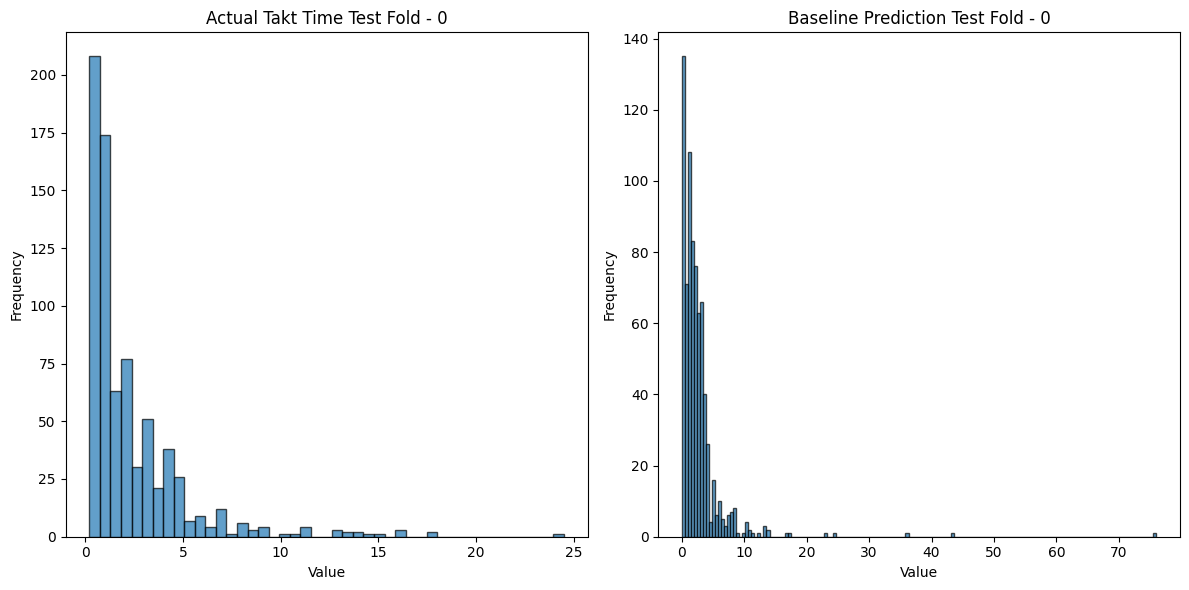

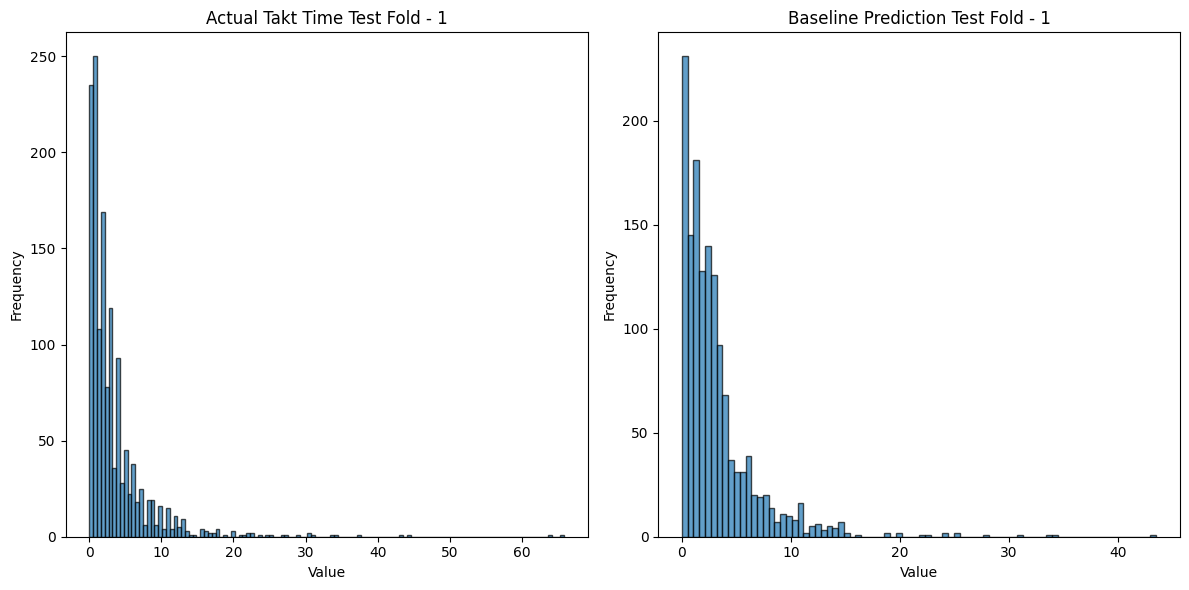

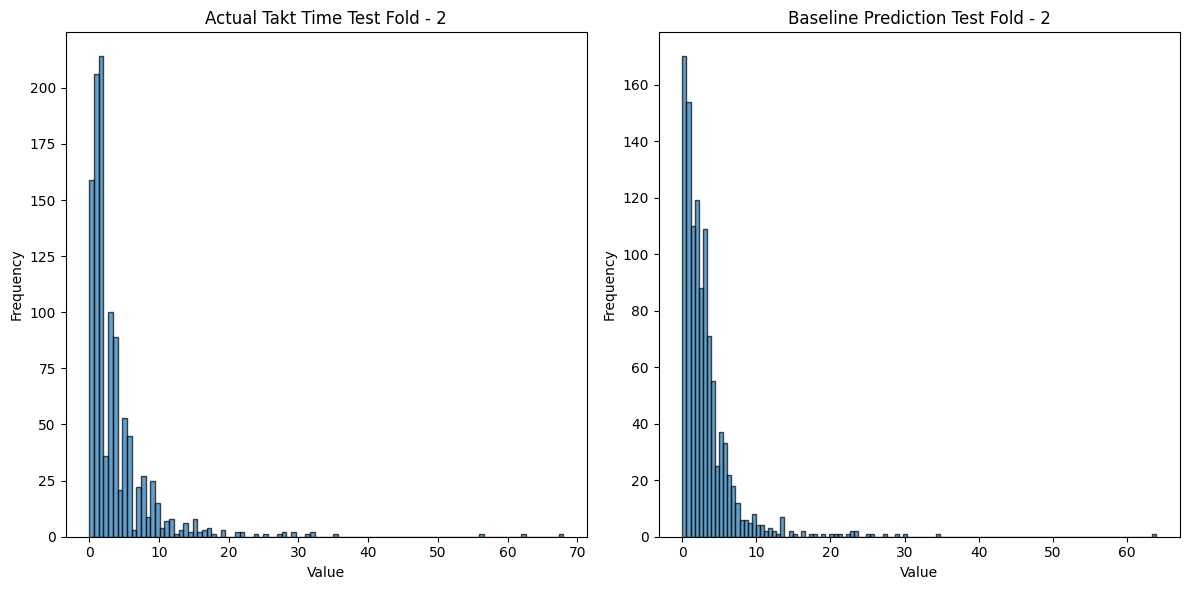

Baseline CV MAE: 2.387316515979903
Baseline CV MAPE: 105400156493960.5
Baseline CV R2: -0.335544288090573
Baseline Validation RMSE:3.684025471629976
Baseline Validation MAE:2.0454510930389627
Baseline Validation MAPE:21783972960994.117
Baseline Validation R2:0.04510745031846608


In [50]:
date_cutoff = '2025-01-01'
n_splits = 3

splitter = DateTimeSeriesSplit(
    date_column="Date",
    n_splits=n_splits
)

ml_results_summary = {}

df_ml_expanded = df_ml.copy() #add_historical_performance(df_ml,12)

baselineModel = BaselineModel(task_history=df_ml_expanded, default_takt=df_all_melted)
baseline_rmse = []
baseline_mape = []
baseline_r2 = []

def plot_baseline_distribution(y_actual, y_prediction, actual_title, prediction_title):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.hist(y_actual, bins='auto', edgecolor='black', alpha=0.7)
    plt.title(actual_title)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    
    # Second plot
    plt.subplot(1, 2, 2)
    plt.hist(y_prediction, bins='auto', edgecolor='black', alpha=0.7)
    plt.title(prediction_title)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show() 

df_train = df_ml_expanded[df_ml_expanded['Date']<date_cutoff]
for i, (train_idx, test_idx) in enumerate(splitter.split(df_train)):
    df_test = df_train.iloc[test_idx]
    y_predict = baselineModel.predict(df_test)
    y_actual = df_test['Total Adj Time Spent'].values

    plot_baseline_distribution(y_actual, y_predict,
                               f"Actual Takt Time Test Fold - {i}",
                               f"Baseline Prediction Test Fold - {i}")
    
    baseline_rmse.append(mean_absolute_error(y_actual, y_predict))
    baseline_mape.append(mean_absolute_percentage_error(y_actual, y_predict))
    baseline_r2.append(r2_score(y_actual, y_predict))

cv_rmse = np.mean(baseline_rmse)
cv_mape = np.mean(baseline_mape)
cv_r2 = np.mean(baseline_r2)

print(f'Baseline CV MAE: {cv_rmse}')
print(f'Baseline CV MAPE: {cv_mape}')
print(f'Baseline CV R2: {cv_r2}')


df_test = df_ml_expanded[df_ml_expanded['Date']>=date_cutoff]
y_predict = baselineModel.predict(df_test)
y_actual = df_test['Total Adj Time Spent'].values
rmse = root_mean_squared_error(y_actual, y_predict)
print(f'Baseline Validation RMSE:{rmse}')
mae = mean_absolute_error(y_actual, y_predict)
print(f'Baseline Validation MAE:{mae}')

mape = mean_absolute_percentage_error(y_actual, y_predict)
print(f'Baseline Validation MAPE:{mape}')

r2 = r2_score(y_actual, y_predict) 
print(f'Baseline Validation R2:{r2}')

ml_results_summary['Baseline']= [baselineModel, cv_r2, rmse, mae,mape,r2]

#### LightGBM

In [51]:
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
import optuna
import numpy as np
import shap
import logging

# Dropper class
class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop):
        self.columns_to_drop = columns_to_drop

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(columns=self.columns_to_drop, errors='ignore')
        
def align_categories(df, cat_cols, unknown_label='Unknown'):
    """
    Ensures consistent categories across cat_cols and adds an 'Unknown' category to handle unseen values.
    """
    df_aligned = df.copy()

    for col in cat_cols:
        # Get all unique values (as strings) and add 'Unknown'
        unique_vals = df_aligned[col].astype(str).unique().tolist()
        if unknown_label not in unique_vals:
            unique_vals.append(unknown_label)
        
        # Set category type with unified categories
        df_aligned[col] = df_aligned[col].astype(str).fillna(unknown_label)
        df_aligned[col] = pd.Categorical(df_aligned[col], categories=unique_vals)
    
    return df_aligned

def show_gbmmodel_interpretation(jaguar_model, X_valid_encoded, category_mappings):
    X_display = X_valid_encoded.copy()

    # Replace encoded values with original category names for display only
    for col, mapping in category_mappings.items():
        X_display[col] = X_display[col].map(mapping)

    explainer = shap.TreeExplainer(jaguar_model)
    shap_values = explainer.shap_values(X_valid_encoded)

    shap.summary_plot(shap_values, X_display, plot_type='bar')
    shap.summary_plot(shap_values, X_display)
    shap.initjs()

    shap.force_plot(explainer.expected_value, shap_values[0], X_display.iloc[0], matplotlib=True)

    shap.plots.waterfall(shap.Explanation(
        values=shap_values[0],
        base_values=explainer.expected_value,
        data=X_display.iloc[0],
        feature_names=X_display.columns.tolist()
    ))

    mean_abs_shap = pd.DataFrame({
        'Feature': X_valid_encoded.columns,
        'Mean_Abs_SHAP': np.abs(shap_values).mean(axis=0)
    }).sort_values('Mean_Abs_SHAP', ascending=False)

    display(mean_abs_shap.head(20))

    top_features = mean_abs_shap['Feature'].head(5)
    for feature in top_features:
        shap.dependence_plot(feature, shap_values, X_valid_encoded, display_features=X_display)

def gbm_hyperparameter_tuning(df_ml, target_col, cat_cols,
                              date_cutoff, n_splits=3, gap=0, window_type='expanding',
                              drop_cols=None):
    if drop_cols is None:
        drop_cols = ['Date']


    df = df_ml.sort_values('Date').reset_index(drop=True)
    df_train = df[df['Date'] < date_cutoff].copy()
    df_valid = df[df['Date'] >= date_cutoff].copy()

    df_train = align_categories(df_train, cat_cols)
    df_valid = align_categories(df_valid, cat_cols)

    category_mappings = {}
    for col in cat_cols:
        df_train[col] = df_train[col].astype('category')
        df_valid[col] = df_valid[col].astype('category')
        category_mappings[col] = dict(enumerate(df_train[col].cat.categories))

    for col in cat_cols:
        df_train[col] = df_train[col].cat.codes
        df_valid[col] = df_valid[col].cat.codes

    y_train = df_train[target_col]
    y_valid = df_valid[target_col]
    X_train = df_train.drop(columns=[target_col])
    X_valid = df_valid.drop(columns=[target_col])

    dropper = ColumnDropper(columns_to_drop=drop_cols)
    X_train_dropped = dropper.fit_transform(X_train)
    X_valid_dropped = dropper.transform(X_valid)

    cat_feature_indices = [X_train_dropped.columns.get_loc(col) for col in cat_cols]

    # --- Step 5: Cross-validation splitter ---
    splitter = DateTimeSeriesSplit(
        date_column='Date',
        n_splits=n_splits,
        gap=gap,
        window_type=window_type
    )

    def objective(trial):
        params = {
            'objective': 'regression',
            'boosting_type': 'gbdt',
            'verbosity': -1,
            'random_state': 42,
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
            'num_leaves': trial.suggest_int('num_leaves', 20, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 15),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100),
            'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
            'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
            'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
            'lambda_l1': trial.suggest_float('lambda_l1', 0, 5),
            'lambda_l2': trial.suggest_float('lambda_l2', 0, 5),
        }

        scores = []
        for train_idx, val_idx in splitter.split(df_train):
            X_tr = X_train_dropped.iloc[train_idx]
            y_tr = y_train.iloc[train_idx]
            X_te = X_train_dropped.iloc[val_idx]
            y_te = y_train.iloc[val_idx]

            lgb_train = lgb.Dataset(X_tr, y_tr, categorical_feature=cat_feature_indices)
            lgb_valid = lgb.Dataset(X_te, y_te, categorical_feature=cat_feature_indices, reference=lgb_train)
        
            model = lgb.train(
                params,
                lgb_train,
                num_boost_round=1000,
                valid_sets=[lgb_valid],
                callbacks=[
                    early_stopping(stopping_rounds=20),
                    log_evaluation(0)  # 0 = silent, or use 100 to log every 100 rounds
                ]
            )

            preds = model.predict(X_te)
            scores.append(r2_score(y_te, preds))

        return np.mean(scores)

    
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=50, show_progress_bar=False)
    
    print("Best parameters:", study.best_params)
    print("Best CV R2:", study.best_value)
    cv_r2 = study.best_value

    best_trial = study.best_trial
    best_params = best_trial.params
    
    lgb_train = lgb.Dataset(X_train_dropped, y_train, categorical_feature=cat_feature_indices)
    lgb_valid = lgb.Dataset(X_valid_dropped, y_valid, categorical_feature=cat_feature_indices, reference=lgb_train)
    
    best_model = lgb.train(
        best_params,
        lgb_train,
        num_boost_round=1000,
        valid_sets=[lgb_valid],
        callbacks=[
            lgb.early_stopping(stopping_rounds=20),
            lgb.log_evaluation(0)
        ]
    )
    y_pred = best_model.predict(X_valid_dropped)
    rmse = root_mean_squared_error(y_valid, y_pred)
    print("Validation RMSE:", rmse)

    mae = mean_absolute_error(y_valid, y_pred)
    print("Validation MAE:", mae)

    mape = mean_absolute_percentage_error(y_valid, y_pred)
    print("Validation MAPE:", mape)

    r2 = r2_score(y_valid, y_pred)
    print("Validation R2:", r2)   
    
    show_gbmmodel_interpretation(best_model, X_valid_dropped, category_mappings)
    return best_model, cv_r2, rmse, mae, mape, r2

[I 2025-05-19 07:39:28,928] A new study created in memory with name: no-name-6b35cd98-71a7-44d7-895d-80059cd500bd
[I 2025-05-19 07:39:29,181] Trial 0 finished with value: 0.2499483523658206 and parameters: {'learning_rate': 0.059090188750245055, 'num_leaves': 288, 'max_depth': 3, 'min_data_in_leaf': 75, 'feature_fraction': 0.7304598771422406, 'bagging_fraction': 0.9893810244898273, 'bagging_freq': 5, 'lambda_l1': 2.3189599618252803, 'lambda_l2': 4.818527369544332}. Best is trial 0 with value: 0.2499483523658206.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[144]	valid_0's l2: 34.0307
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[37]	valid_0's l2: 13.4788
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[125]	valid_0's l2: 9.71113
Training until validation scores don't improve for 20 rounds


[I 2025-05-19 07:39:29,340] Trial 1 finished with value: 0.23397077246672715 and parameters: {'learning_rate': 0.06070201017362532, 'num_leaves': 298, 'max_depth': 4, 'min_data_in_leaf': 66, 'feature_fraction': 0.8828741042887107, 'bagging_fraction': 0.9470422005898058, 'bagging_freq': 4, 'lambda_l1': 2.6600329591172316, 'lambda_l2': 4.970697394929992}. Best is trial 0 with value: 0.2499483523658206.


Early stopping, best iteration is:
[104]	valid_0's l2: 33.8349
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[24]	valid_0's l2: 14.2385
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[48]	valid_0's l2: 9.75758
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[105]	valid_0's l2: 30.5664
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[21]	valid_0's l2: 14.3514
Training until validation scores don't improve for 20 rounds


[I 2025-05-19 07:39:29,542] Trial 2 finished with value: 0.26820392986357494 and parameters: {'learning_rate': 0.07826161813995453, 'num_leaves': 298, 'max_depth': 14, 'min_data_in_leaf': 25, 'feature_fraction': 0.5672729257162961, 'bagging_fraction': 0.5344701468655788, 'bagging_freq': 7, 'lambda_l1': 2.0648799878655404, 'lambda_l2': 3.6373860139800933}. Best is trial 2 with value: 0.26820392986357494.
[I 2025-05-19 07:39:29,685] Trial 3 finished with value: 0.235243131213843 and parameters: {'learning_rate': 0.12150212334924064, 'num_leaves': 210, 'max_depth': 13, 'min_data_in_leaf': 66, 'feature_fraction': 0.9742328006020053, 'bagging_fraction': 0.8766698453168669, 'bagging_freq': 5, 'lambda_l1': 1.8097547891296144, 'lambda_l2': 2.1171861547858963}. Best is trial 2 with value: 0.26820392986357494.


Early stopping, best iteration is:
[70]	valid_0's l2: 9.18535
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[66]	valid_0's l2: 33.1862
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[37]	valid_0's l2: 14.9027
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[33]	valid_0's l2: 9.21019
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[105]	valid_0's l2: 32.4786
Training until validation scores don't improve for 20 rounds


[I 2025-05-19 07:39:29,794] Trial 4 finished with value: 0.24548180378009213 and parameters: {'learning_rate': 0.159839374181901, 'num_leaves': 163, 'max_depth': 10, 'min_data_in_leaf': 98, 'feature_fraction': 0.9310950661124529, 'bagging_fraction': 0.5316453755004624, 'bagging_freq': 1, 'lambda_l1': 0.17146507957470747, 'lambda_l2': 1.6346665030746328}. Best is trial 2 with value: 0.26820392986357494.


Early stopping, best iteration is:
[16]	valid_0's l2: 13.9196
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[33]	valid_0's l2: 10.0656
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[105]	valid_0's l2: 33.3741
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[24]	valid_0's l2: 13.6269
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[48]	valid_0's l2: 9.39403


[I 2025-05-19 07:39:29,948] Trial 5 finished with value: 0.2580462889100558 and parameters: {'learning_rate': 0.06404241998819063, 'num_leaves': 290, 'max_depth': 12, 'min_data_in_leaf': 55, 'feature_fraction': 0.7484577672166194, 'bagging_fraction': 0.8016831758039031, 'bagging_freq': 7, 'lambda_l1': 1.7595535075745883, 'lambda_l2': 1.8892816735401685}. Best is trial 2 with value: 0.26820392986357494.
[I 2025-05-19 07:39:30,080] Trial 6 finished with value: 0.24519605331951178 and parameters: {'learning_rate': 0.08753032757837131, 'num_leaves': 184, 'max_depth': 6, 'min_data_in_leaf': 97, 'feature_fraction': 0.6963686894045595, 'bagging_fraction': 0.5781020722858526, 'bagging_freq': 1, 'lambda_l1': 1.13978560215023, 'lambda_l2': 4.894162866251571}. Best is trial 2 with value: 0.26820392986357494.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[157]	valid_0's l2: 33.1548
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[20]	valid_0's l2: 14.064
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[132]	valid_0's l2: 9.64995
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[165]	valid_0's l2: 33.4574
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[23]	valid_0's l2: 13.8295


[I 2025-05-19 07:39:30,233] Trial 7 finished with value: 0.2504760251353079 and parameters: {'learning_rate': 0.07189131058305487, 'num_leaves': 169, 'max_depth': 15, 'min_data_in_leaf': 94, 'feature_fraction': 0.638022792503053, 'bagging_fraction': 0.7214824041918042, 'bagging_freq': 3, 'lambda_l1': 2.3446727925979443, 'lambda_l2': 4.703292968238644}. Best is trial 2 with value: 0.26820392986357494.
[I 2025-05-19 07:39:30,331] Trial 8 finished with value: 0.2415855467141211 and parameters: {'learning_rate': 0.15746846698242958, 'num_leaves': 20, 'max_depth': 14, 'min_data_in_leaf': 34, 'feature_fraction': 0.6559381921429346, 'bagging_fraction': 0.6554682588981445, 'bagging_freq': 6, 'lambda_l1': 2.279306184181084, 'lambda_l2': 1.3594689018137796}. Best is trial 2 with value: 0.26820392986357494.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[91]	valid_0's l2: 9.52135
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[33]	valid_0's l2: 32.669
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[6]	valid_0's l2: 14.8283
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[39]	valid_0's l2: 9.1752
Training until validation scores don't improve for 20 rounds


[I 2025-05-19 07:39:30,538] Trial 9 finished with value: 0.23339002383731636 and parameters: {'learning_rate': 0.14050213105024256, 'num_leaves': 247, 'max_depth': 15, 'min_data_in_leaf': 59, 'feature_fraction': 0.8702837014995797, 'bagging_fraction': 0.7208161301190805, 'bagging_freq': 2, 'lambda_l1': 4.017356406754648, 'lambda_l2': 1.5402240817379482}. Best is trial 2 with value: 0.26820392986357494.


Early stopping, best iteration is:
[110]	valid_0's l2: 32.8546
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[6]	valid_0's l2: 15.0608
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[46]	valid_0's l2: 9.26048
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[382]	valid_0's l2: 31.6866
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[70]	valid_0's l2: 14.2971
Training until validation scores don't improve for 20 rounds


[I 2025-05-19 07:39:31,060] Trial 10 finished with value: 0.24902540235854873 and parameters: {'learning_rate': 0.012969653622949703, 'num_leaves': 81, 'max_depth': 8, 'min_data_in_leaf': 11, 'feature_fraction': 0.5016369482265748, 'bagging_fraction': 0.6214262127675569, 'bagging_freq': 7, 'lambda_l1': 4.94162893424166, 'lambda_l2': 3.384393883439089}. Best is trial 2 with value: 0.26820392986357494.


Early stopping, best iteration is:
[268]	valid_0's l2: 9.77907
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[189]	valid_0's l2: 33.3122
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[72]	valid_0's l2: 13.44
Training until validation scores don't improve for 20 rounds


[I 2025-05-19 07:39:31,506] Trial 11 finished with value: 0.26545921959584196 and parameters: {'learning_rate': 0.022725179860361766, 'num_leaves': 245, 'max_depth': 11, 'min_data_in_leaf': 39, 'feature_fraction': 0.5080752741195113, 'bagging_fraction': 0.8298903021029617, 'bagging_freq': 7, 'lambda_l1': 3.3426247720793327, 'lambda_l2': 3.283645301118301}. Best is trial 2 with value: 0.26820392986357494.


Early stopping, best iteration is:
[272]	valid_0's l2: 9.24859
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[384]	valid_0's l2: 33.0877
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[71]	valid_0's l2: 14.2661
Training until validation scores don't improve for 20 rounds


[I 2025-05-19 07:39:32,155] Trial 12 finished with value: 0.24623066010879968 and parameters: {'learning_rate': 0.012175565434195498, 'num_leaves': 227, 'max_depth': 11, 'min_data_in_leaf': 34, 'feature_fraction': 0.5261600000788779, 'bagging_fraction': 0.8256036083502938, 'bagging_freq': 7, 'lambda_l1': 3.3576922780009566, 'lambda_l2': 3.3544096669489907}. Best is trial 2 with value: 0.26820392986357494.


Early stopping, best iteration is:
[379]	valid_0's l2: 9.39843
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[17]	valid_0's l2: 34.2118
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[8]	valid_0's l2: 13.4894
Training until validation scores don't improve for 20 rounds


[I 2025-05-19 07:39:32,307] Trial 13 finished with value: 0.26170350320125096 and parameters: {'learning_rate': 0.19643136838291636, 'num_leaves': 253, 'max_depth': 8, 'min_data_in_leaf': 28, 'feature_fraction': 0.5838598281131344, 'bagging_fraction': 0.9064839039642393, 'bagging_freq': 6, 'lambda_l1': 3.611677703544588, 'lambda_l2': 0.0061211891523855755}. Best is trial 2 with value: 0.26820392986357494.


Early stopping, best iteration is:
[25]	valid_0's l2: 9.0271
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[162]	valid_0's l2: 32.2576
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[45]	valid_0's l2: 12.7546
Training until validation scores don't improve for 20 rounds


[I 2025-05-19 07:39:32,696] Trial 14 finished with value: 0.2891838645670464 and parameters: {'learning_rate': 0.03389332141180601, 'num_leaves': 114, 'max_depth': 12, 'min_data_in_leaf': 19, 'feature_fraction': 0.5698291943860265, 'bagging_fraction': 0.7898839560482266, 'bagging_freq': 6, 'lambda_l1': 3.2008543748942846, 'lambda_l2': 3.529425393000138}. Best is trial 14 with value: 0.2891838645670464.


Early stopping, best iteration is:
[162]	valid_0's l2: 9.22165
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[75]	valid_0's l2: 32.4588
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[40]	valid_0's l2: 13.645
Training until validation scores don't improve for 20 rounds


[I 2025-05-19 07:39:33,136] Trial 15 finished with value: 0.2605200457552821 and parameters: {'learning_rate': 0.04346798338459883, 'num_leaves': 120, 'max_depth': 13, 'min_data_in_leaf': 11, 'feature_fraction': 0.5944351632218801, 'bagging_fraction': 0.5103472239370092, 'bagging_freq': 5, 'lambda_l1': 0.8941966973818072, 'lambda_l2': 4.03710412202345}. Best is trial 14 with value: 0.2891838645670464.


Early stopping, best iteration is:
[81]	valid_0's l2: 9.61191
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[90]	valid_0's l2: 31.3701
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[18]	valid_0's l2: 13.9146
Training until validation scores don't improve for 20 rounds


[I 2025-05-19 07:39:33,374] Trial 16 finished with value: 0.2745328308251295 and parameters: {'learning_rate': 0.09669592279787081, 'num_leaves': 123, 'max_depth': 9, 'min_data_in_leaf': 22, 'feature_fraction': 0.8211699534026755, 'bagging_fraction': 0.6748515168014471, 'bagging_freq': 6, 'lambda_l1': 4.377232727552292, 'lambda_l2': 2.7314857894024334}. Best is trial 14 with value: 0.2891838645670464.


Early stopping, best iteration is:
[43]	valid_0's l2: 9.02938
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[80]	valid_0's l2: 32.6534
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[10]	valid_0's l2: 14.6907
Training until validation scores don't improve for 20 rounds


[I 2025-05-19 07:39:33,635] Trial 17 finished with value: 0.24033670247833205 and parameters: {'learning_rate': 0.1143980552931251, 'num_leaves': 123, 'max_depth': 9, 'min_data_in_leaf': 45, 'feature_fraction': 0.8044003939861697, 'bagging_fraction': 0.6845530267288642, 'bagging_freq': 4, 'lambda_l1': 4.877709976660138, 'lambda_l2': 2.743153701305714}. Best is trial 14 with value: 0.2891838645670464.
[I 2025-05-19 07:39:33,798] Trial 18 finished with value: 0.2690859439805294 and parameters: {'learning_rate': 0.10022841194331064, 'num_leaves': 71, 'max_depth': 7, 'min_data_in_leaf': 20, 'feature_fraction': 0.7986313942538267, 'bagging_fraction': 0.7811534475300498, 'bagging_freq': 6, 'lambda_l1': 4.24393997499163, 'lambda_l2': 2.602655141617535}. Best is trial 14 with value: 0.2891838645670464.


Early stopping, best iteration is:
[51]	valid_0's l2: 9.39874
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[32]	valid_0's l2: 33.6275
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[18]	valid_0's l2: 12.9672
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[33]	valid_0's l2: 9.46526


[I 2025-05-19 07:39:33,992] Trial 19 finished with value: 0.2645289137180557 and parameters: {'learning_rate': 0.038926835660483175, 'num_leaves': 126, 'max_depth': 5, 'min_data_in_leaf': 17, 'feature_fraction': 0.8115633360592795, 'bagging_fraction': 0.7481219119396146, 'bagging_freq': 3, 'lambda_l1': 2.8335665348337415, 'lambda_l2': 0.7095612271174727}. Best is trial 14 with value: 0.2891838645670464.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[85]	valid_0's l2: 32.5343
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[21]	valid_0's l2: 13.5185
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[85]	valid_0's l2: 9.51832
Training until validation scores don't improve for 20 rounds


[I 2025-05-19 07:39:34,213] Trial 20 finished with value: 0.24331450058357149 and parameters: {'learning_rate': 0.038783539010526724, 'num_leaves': 76, 'max_depth': 10, 'min_data_in_leaf': 47, 'feature_fraction': 0.8573903038642157, 'bagging_fraction': 0.607593891105358, 'bagging_freq': 6, 'lambda_l1': 4.332953735935478, 'lambda_l2': 3.9484453102495727}. Best is trial 14 with value: 0.2891838645670464.


Early stopping, best iteration is:
[239]	valid_0's l2: 32.3243
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[18]	valid_0's l2: 14.5286
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[91]	valid_0's l2: 9.55853
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[62]	valid_0's l2: 32.9802


[I 2025-05-19 07:39:34,401] Trial 21 finished with value: 0.28452300089415566 and parameters: {'learning_rate': 0.09703287122033234, 'num_leaves': 87, 'max_depth': 7, 'min_data_in_leaf': 21, 'feature_fraction': 0.8014715804980458, 'bagging_fraction': 0.7756092695321506, 'bagging_freq': 6, 'lambda_l1': 4.302689369646978, 'lambda_l2': 2.580989943025476}. Best is trial 14 with value: 0.2891838645670464.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[18]	valid_0's l2: 12.7437
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[36]	valid_0's l2: 9.1841
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[29]	valid_0's l2: 32.2421
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[5]	valid_0's l2: 14.7461
Training until validation scores don't improve for 20 rounds


[I 2025-05-19 07:39:34,554] Trial 22 finished with value: 0.24616671492743733 and parameters: {'learning_rate': 0.13022362744378815, 'num_leaves': 96, 'max_depth': 7, 'min_data_in_leaf': 23, 'feature_fraction': 0.6962073351747353, 'bagging_fraction': 0.6710770450815384, 'bagging_freq': 5, 'lambda_l1': 3.814656920101079, 'lambda_l2': 2.876691676600853}. Best is trial 14 with value: 0.2891838645670464.


Early stopping, best iteration is:
[35]	valid_0's l2: 9.20304
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[90]	valid_0's l2: 32.334
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[16]	valid_0's l2: 13.5695
Training until validation scores don't improve for 20 rounds


[I 2025-05-19 07:39:34,760] Trial 23 finished with value: 0.2655114506189634 and parameters: {'learning_rate': 0.09710251400700458, 'num_leaves': 46, 'max_depth': 9, 'min_data_in_leaf': 30, 'feature_fraction': 0.7796444959347855, 'bagging_fraction': 0.8718992232282121, 'bagging_freq': 6, 'lambda_l1': 4.5593748472826405, 'lambda_l2': 2.1705910192868343}. Best is trial 14 with value: 0.2891838645670464.


Early stopping, best iteration is:
[64]	valid_0's l2: 9.49098
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[52]	valid_0's l2: 33.2342
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[30]	valid_0's l2: 13.2149
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[26]	valid_0's l2: 9.20015


[I 2025-05-19 07:39:34,933] Trial 24 finished with value: 0.2719335076670633 and parameters: {'learning_rate': 0.08761670153165703, 'num_leaves': 138, 'max_depth': 6, 'min_data_in_leaf': 17, 'feature_fraction': 0.921356178790153, 'bagging_fraction': 0.7656774871789319, 'bagging_freq': 4, 'lambda_l1': 2.9683290834549805, 'lambda_l2': 4.265757332480985}. Best is trial 14 with value: 0.2891838645670464.
[I 2025-05-19 07:39:35,167] Trial 25 finished with value: 0.25042310247303606 and parameters: {'learning_rate': 0.14832304017989673, 'num_leaves': 144, 'max_depth': 10, 'min_data_in_leaf': 40, 'feature_fraction': 0.8306072925277203, 'bagging_fraction': 0.7294413799350858, 'bagging_freq': 5, 'lambda_l1': 4.5983577019654955, 'lambda_l2': 3.0006219273129333}. Best is trial 14 with value: 0.2891838645670464.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[75]	valid_0's l2: 31.9551
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[13]	valid_0's l2: 14.5594
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[35]	valid_0's l2: 9.30818
Training until validation scores don't improve for 20 rounds


[I 2025-05-19 07:39:35,341] Trial 26 finished with value: 0.2589362692951993 and parameters: {'learning_rate': 0.18020159294811744, 'num_leaves': 95, 'max_depth': 8, 'min_data_in_leaf': 12, 'feature_fraction': 0.7682632855042796, 'bagging_fraction': 0.6913673900032239, 'bagging_freq': 6, 'lambda_l1': 3.335998791931042, 'lambda_l2': 1.0351059798173328}. Best is trial 14 with value: 0.2891838645670464.


Early stopping, best iteration is:
[18]	valid_0's l2: 33.7275
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[7]	valid_0's l2: 13.669
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[18]	valid_0's l2: 9.16081
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[51]	valid_0's l2: 32.3903
Training until validation scores don't improve for 20 rounds


[I 2025-05-19 07:39:35,554] Trial 27 finished with value: 0.2605314545822837 and parameters: {'learning_rate': 0.10699011501132225, 'num_leaves': 50, 'max_depth': 12, 'min_data_in_leaf': 19, 'feature_fraction': 0.7158261834804959, 'bagging_fraction': 0.8187720809162111, 'bagging_freq': 5, 'lambda_l1': 4.075757526671128, 'lambda_l2': 2.321883403323396}. Best is trial 14 with value: 0.2891838645670464.


Early stopping, best iteration is:
[19]	valid_0's l2: 13.7079
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[30]	valid_0's l2: 9.56855
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[118]	valid_0's l2: 33.2945
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[24]	valid_0's l2: 14.0741


[I 2025-05-19 07:39:35,776] Trial 28 finished with value: 0.24655464717594774 and parameters: {'learning_rate': 0.04821777146355023, 'num_leaves': 102, 'max_depth': 9, 'min_data_in_leaf': 47, 'feature_fraction': 0.6661071010379365, 'bagging_fraction': 0.8520578772254965, 'bagging_freq': 6, 'lambda_l1': 3.0349004848789747, 'lambda_l2': 3.673564800091069}. Best is trial 14 with value: 0.2891838645670464.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[76]	valid_0's l2: 9.5137
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[102]	valid_0's l2: 33.8767
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[67]	valid_0's l2: 13.0065


[I 2025-05-19 07:39:35,981] Trial 29 finished with value: 0.26230638300941733 and parameters: {'learning_rate': 0.028507966137680328, 'num_leaves': 190, 'max_depth': 3, 'min_data_in_leaf': 31, 'feature_fraction': 0.9050790685947934, 'bagging_fraction': 0.9371243857617368, 'bagging_freq': 3, 'lambda_l1': 3.5674295772982427, 'lambda_l2': 4.395181483630804}. Best is trial 14 with value: 0.2891838645670464.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[126]	valid_0's l2: 9.66829
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[66]	valid_0's l2: 32.0375
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[5]	valid_0's l2: 14.7254
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[35]	valid_0's l2: 9.33044


[I 2025-05-19 07:39:36,129] Trial 30 finished with value: 0.24571953981291306 and parameters: {'learning_rate': 0.12493061242657749, 'num_leaves': 53, 'max_depth': 7, 'min_data_in_leaf': 40, 'feature_fraction': 0.7389238477850768, 'bagging_fraction': 0.6374442777062155, 'bagging_freq': 5, 'lambda_l1': 4.458987311826538, 'lambda_l2': 3.0573296603261473}. Best is trial 14 with value: 0.2891838645670464.
[I 2025-05-19 07:39:36,291] Trial 31 finished with value: 0.2850660873485727 and parameters: {'learning_rate': 0.08419213319804619, 'num_leaves': 143, 'max_depth': 5, 'min_data_in_leaf': 18, 'feature_fraction': 0.9562556419941151, 'bagging_fraction': 0.7722191147491567, 'bagging_freq': 4, 'lambda_l1': 2.9704722991006416, 'lambda_l2': 4.28274552577653}. Best is trial 14 with value: 0.2891838645670464.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[52]	valid_0's l2: 32.9269
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[32]	valid_0's l2: 12.8038
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[28]	valid_0's l2: 9.11055
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[108]	valid_0's l2: 32.2664
Training until validation scores don't improve for 20 rounds


[I 2025-05-19 07:39:36,492] Trial 32 finished with value: 0.27198628110995066 and parameters: {'learning_rate': 0.05471334167174355, 'num_leaves': 140, 'max_depth': 5, 'min_data_in_leaf': 24, 'feature_fraction': 0.9828292224495774, 'bagging_fraction': 0.7869233983089842, 'bagging_freq': 4, 'lambda_l1': 3.8384781935472283, 'lambda_l2': 3.7370979312068346}. Best is trial 14 with value: 0.2891838645670464.


Early stopping, best iteration is:
[28]	valid_0's l2: 13.4539
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[52]	valid_0's l2: 9.31624
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[124]	valid_0's l2: 34.2787
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[25]	valid_0's l2: 13.7081


[I 2025-05-19 07:39:36,711] Trial 33 finished with value: 0.24610760359943895 and parameters: {'learning_rate': 0.08053795390418124, 'num_leaves': 112, 'max_depth': 4, 'min_data_in_leaf': 76, 'feature_fraction': 0.8401949349587292, 'bagging_fraction': 0.9778940769928078, 'bagging_freq': 4, 'lambda_l1': 2.629239988273304, 'lambda_l2': 2.5247799825028845}. Best is trial 14 with value: 0.2891838645670464.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[153]	valid_0's l2: 9.55277
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[77]	valid_0's l2: 32.8096
Training until validation scores don't improve for 20 rounds


[I 2025-05-19 07:39:36,911] Trial 34 finished with value: 0.268392258106802 and parameters: {'learning_rate': 0.06865334808526714, 'num_leaves': 148, 'max_depth': 6, 'min_data_in_leaf': 17, 'feature_fraction': 0.8855390762980004, 'bagging_fraction': 0.7459881499961226, 'bagging_freq': 5, 'lambda_l1': 3.0084738400032194, 'lambda_l2': 4.512880916980067}. Best is trial 14 with value: 0.2891838645670464.


Early stopping, best iteration is:
[50]	valid_0's l2: 13.6238
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[34]	valid_0's l2: 9.09399
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[52]	valid_0's l2: 31.6666
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[31]	valid_0's l2: 13.2825
Training until validation scores don't improve for 20 rounds


[I 2025-05-19 07:39:37,135] Trial 35 finished with value: 0.2827085518549757 and parameters: {'learning_rate': 0.11296353442503446, 'num_leaves': 180, 'max_depth': 5, 'min_data_in_leaf': 24, 'feature_fraction': 0.9944426904321848, 'bagging_fraction': 0.7116352363177565, 'bagging_freq': 4, 'lambda_l1': 4.72816403118897, 'lambda_l2': 3.917251850855828}. Best is trial 14 with value: 0.2891838645670464.
[I 2025-05-19 07:39:37,277] Trial 36 finished with value: 0.27178002605675655 and parameters: {'learning_rate': 0.1116844953282624, 'num_leaves': 176, 'max_depth': 3, 'min_data_in_leaf': 26, 'feature_fraction': 0.9444106096298412, 'bagging_fraction': 0.7075146286793894, 'bagging_freq': 3, 'lambda_l1': 4.751165487164339, 'lambda_l2': 4.179971761337785}. Best is trial 14 with value: 0.2891838645670464.


Early stopping, best iteration is:
[28]	valid_0's l2: 9.19881
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[60]	valid_0's l2: 31.446
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[24]	valid_0's l2: 13.7509
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[33]	valid_0's l2: 9.32229


[I 2025-05-19 07:39:37,448] Trial 37 finished with value: 0.25275271471917793 and parameters: {'learning_rate': 0.1355990387515798, 'num_leaves': 199, 'max_depth': 5, 'min_data_in_leaf': 78, 'feature_fraction': 0.9987871437700168, 'bagging_fraction': 0.7652748636192654, 'bagging_freq': 2, 'lambda_l1': 1.9196127227838238, 'lambda_l2': 3.868041501433741}. Best is trial 14 with value: 0.2891838645670464.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[82]	valid_0's l2: 33.1752
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[15]	valid_0's l2: 13.8416
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[42]	valid_0's l2: 9.50394
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[60]	valid_0's l2: 31.9598


[I 2025-05-19 07:39:37,615] Trial 38 finished with value: 0.2678406717172878 and parameters: {'learning_rate': 0.11982172911403152, 'num_leaves': 154, 'max_depth': 4, 'min_data_in_leaf': 10, 'feature_fraction': 0.9575039906676043, 'bagging_fraction': 0.857002802144338, 'bagging_freq': 4, 'lambda_l1': 1.5122322500149417, 'lambda_l2': 4.629014653491139}. Best is trial 14 with value: 0.2891838645670464.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[13]	valid_0's l2: 13.1359
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[22]	valid_0's l2: 10.0047
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[89]	valid_0's l2: 33.7141
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[24]	valid_0's l2: 14.5863
Training until validation scores don't improve for 20 rounds


[I 2025-05-19 07:39:37,803] Trial 39 finished with value: 0.23273087922716126 and parameters: {'learning_rate': 0.0844685646836798, 'num_leaves': 217, 'max_depth': 5, 'min_data_in_leaf': 88, 'feature_fraction': 0.9595114469922842, 'bagging_fraction': 0.8996820602413105, 'bagging_freq': 2, 'lambda_l1': 2.4636460217522744, 'lambda_l2': 4.9537982994426075}. Best is trial 14 with value: 0.2891838645670464.


Early stopping, best iteration is:
[75]	valid_0's l2: 9.48112
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[80]	valid_0's l2: 32.8007
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[32]	valid_0's l2: 11.8938
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[28]	valid_0's l2: 9.49515


[I 2025-05-19 07:39:37,985] Trial 40 finished with value: 0.29839541420747023 and parameters: {'learning_rate': 0.055634022903413224, 'num_leaves': 165, 'max_depth': 6, 'min_data_in_leaf': 15, 'feature_fraction': 0.9076544306346577, 'bagging_fraction': 0.8010003161160988, 'bagging_freq': 4, 'lambda_l1': 4.0077146647710356, 'lambda_l2': 3.53919137077412}. Best is trial 40 with value: 0.29839541420747023.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[68]	valid_0's l2: 32.5702
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[32]	valid_0's l2: 11.9872
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[26]	valid_0's l2: 9.34484


[I 2025-05-19 07:39:38,263] Trial 41 finished with value: 0.3010974093871351 and parameters: {'learning_rate': 0.06129029447191972, 'num_leaves': 164, 'max_depth': 6, 'min_data_in_leaf': 15, 'feature_fraction': 0.906662528861151, 'bagging_fraction': 0.7951660601117297, 'bagging_freq': 4, 'lambda_l1': 4.0039292779116655, 'lambda_l2': 3.4004339691598204}. Best is trial 41 with value: 0.3010974093871351.
[I 2025-05-19 07:39:38,498] Trial 42 finished with value: 0.2872983403335548 and parameters: {'learning_rate': 0.056843370907026125, 'num_leaves': 163, 'max_depth': 6, 'min_data_in_leaf': 15, 'feature_fraction': 0.8949898333244958, 'bagging_fraction': 0.8077438826124334, 'bagging_freq': 3, 'lambda_l1': 3.9189450720515864, 'lambda_l2': 3.525364785169929}. Best is trial 41 with value: 0.3010974093871351.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[87]	valid_0's l2: 32.052
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[32]	valid_0's l2: 12.9025
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[39]	valid_0's l2: 9.23487


[I 2025-05-19 07:39:38,699] Trial 43 finished with value: 0.2846959878436966 and parameters: {'learning_rate': 0.06331597596570418, 'num_leaves': 162, 'max_depth': 6, 'min_data_in_leaf': 15, 'feature_fraction': 0.9014595136178164, 'bagging_fraction': 0.7986595576105291, 'bagging_freq': 3, 'lambda_l1': 3.6406923477821356, 'lambda_l2': 3.528139072692214}. Best is trial 41 with value: 0.3010974093871351.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[86]	valid_0's l2: 31.9046
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[21]	valid_0's l2: 12.8946
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[31]	valid_0's l2: 9.43522


[I 2025-05-19 07:39:38,889] Trial 44 finished with value: 0.29452175755357446 and parameters: {'learning_rate': 0.05168368182498333, 'num_leaves': 163, 'max_depth': 4, 'min_data_in_leaf': 15, 'feature_fraction': 0.9247025405319645, 'bagging_fraction': 0.811605667725488, 'bagging_freq': 3, 'lambda_l1': 3.94247216656231, 'lambda_l2': 3.2334274261513043}. Best is trial 41 with value: 0.3010974093871351.


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[87]	valid_0's l2: 31.6548
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[35]	valid_0's l2: 12.594
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[39]	valid_0's l2: 9.36826
Training until validation scores don't improve for 20 rounds


[I 2025-05-19 07:39:39,077] Trial 45 finished with value: 0.2924853364771352 and parameters: {'learning_rate': 0.05509009069071872, 'num_leaves': 199, 'max_depth': 4, 'min_data_in_leaf': 14, 'feature_fraction': 0.9221433662046623, 'bagging_fraction': 0.8394093449197108, 'bagging_freq': 3, 'lambda_l1': 4.01926470507005, 'lambda_l2': 3.1886475590241776}. Best is trial 41 with value: 0.3010974093871351.


Early stopping, best iteration is:
[81]	valid_0's l2: 32.1274
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[36]	valid_0's l2: 12.4481
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[39]	valid_0's l2: 9.44683
Training until validation scores don't improve for 20 rounds


[I 2025-05-19 07:39:39,368] Trial 46 finished with value: 0.2637210682931721 and parameters: {'learning_rate': 0.032437589876138845, 'num_leaves': 201, 'max_depth': 3, 'min_data_in_leaf': 35, 'feature_fraction': 0.929123217325935, 'bagging_fraction': 0.8428242220465179, 'bagging_freq': 2, 'lambda_l1': 3.376237356309203, 'lambda_l2': 3.1731686737390827}. Best is trial 41 with value: 0.3010974093871351.


Early stopping, best iteration is:
[166]	valid_0's l2: 32.9111
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[55]	valid_0's l2: 13.297
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[76]	valid_0's l2: 9.65654
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[107]	valid_0's l2: 32.6968
Training until validation scores don't improve for 20 rounds


[I 2025-05-19 07:39:39,563] Trial 47 finished with value: 0.27478907609522396 and parameters: {'learning_rate': 0.04921484369734267, 'num_leaves': 233, 'max_depth': 4, 'min_data_in_leaf': 14, 'feature_fraction': 0.8598635292403992, 'bagging_fraction': 0.9018182340798606, 'bagging_freq': 3, 'lambda_l1': 4.098519662147323, 'lambda_l2': 3.2711844025692995}. Best is trial 41 with value: 0.3010974093871351.


Early stopping, best iteration is:
[45]	valid_0's l2: 12.8584
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[48]	valid_0's l2: 9.66594
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[114]	valid_0's l2: 33.2537
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[21]	valid_0's l2: 13.8699
Training until validation scores don't improve for 20 rounds


[I 2025-05-19 07:39:39,731] Trial 48 finished with value: 0.24887802723079244 and parameters: {'learning_rate': 0.06854440579274397, 'num_leaves': 277, 'max_depth': 4, 'min_data_in_leaf': 66, 'feature_fraction': 0.9166290283215583, 'bagging_fraction': 0.83395858170448, 'bagging_freq': 3, 'lambda_l1': 3.6080969855370744, 'lambda_l2': 3.41630353066174}. Best is trial 41 with value: 0.3010974093871351.


Early stopping, best iteration is:
[39]	valid_0's l2: 9.63898
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[252]	valid_0's l2: 32.2191
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[91]	valid_0's l2: 13.6698
Training until validation scores don't improve for 20 rounds


[I 2025-05-19 07:39:40,386] Trial 49 finished with value: 0.2561339197312448 and parameters: {'learning_rate': 0.017253990358628332, 'num_leaves': 191, 'max_depth': 13, 'min_data_in_leaf': 10, 'feature_fraction': 0.6155592069594868, 'bagging_fraction': 0.8781200383480354, 'bagging_freq': 1, 'lambda_l1': 0.13825966545049928, 'lambda_l2': 2.966685572716092}. Best is trial 41 with value: 0.3010974093871351.


Early stopping, best iteration is:
[167]	valid_0's l2: 9.9037
Best parameters: {'learning_rate': 0.06129029447191972, 'num_leaves': 164, 'max_depth': 6, 'min_data_in_leaf': 15, 'feature_fraction': 0.906662528861151, 'bagging_fraction': 0.7951660601117297, 'bagging_freq': 4, 'lambda_l1': 4.0039292779116655, 'lambda_l2': 3.4004339691598204}
Best CV R2: 0.3010974093871351
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[8]	valid_0's l2: 14.1261
Validation RMSE: 3.7584734930842254
Validation MAE: 2.6827984724726712
Validation MAPE: 25134101556919.832
Validation R2: 0.006123916981319422


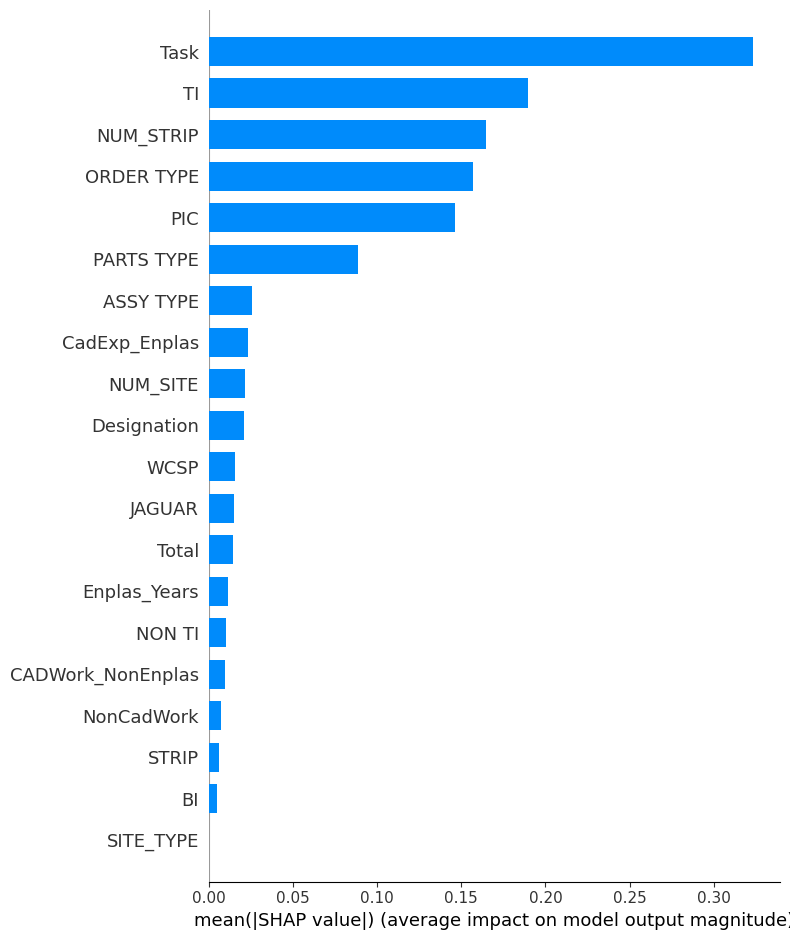

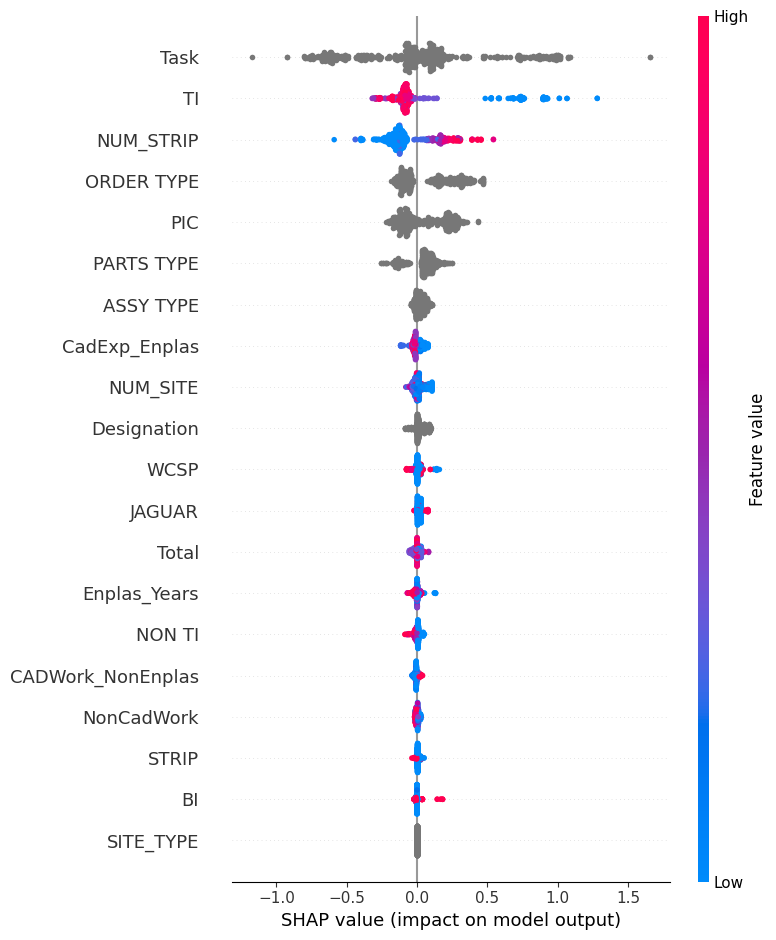

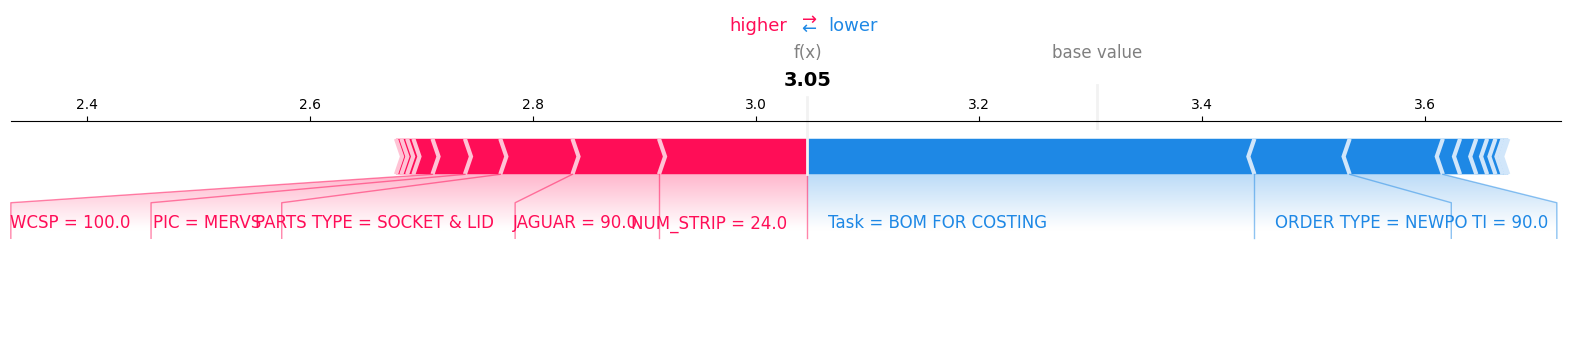

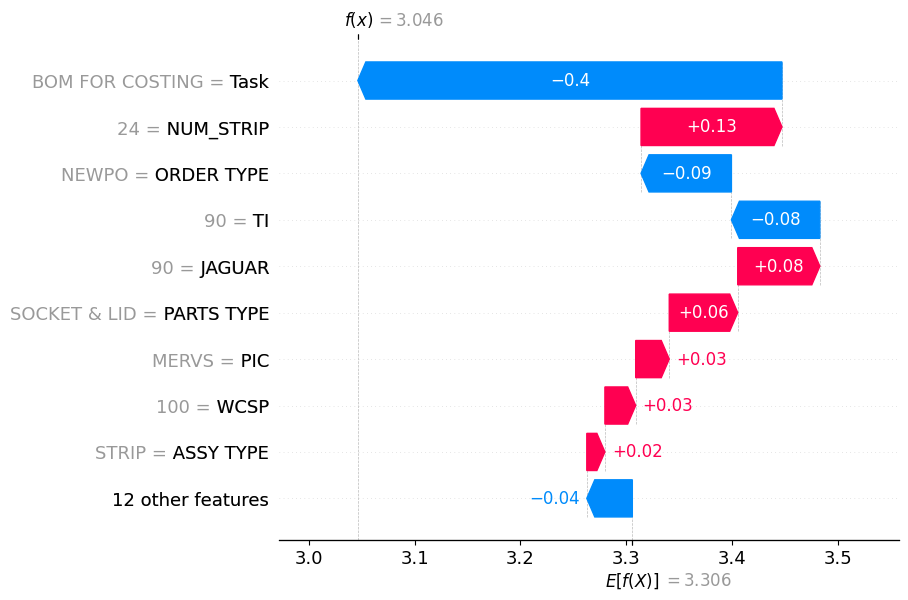

,Feature,Mean_Abs_SHAP
0,Task,0.323273
10,TI,0.189544
19,NUM_STRIP,0.164561
3,ORDER TYPE,0.156920
20,PIC,0.146359
2,PARTS TYPE,0.088754
1,ASSY TYPE,0.025528
13,CadExp_Enplas,0.023092
18,NUM_SITE,0.021491
12,Designation,0.020652


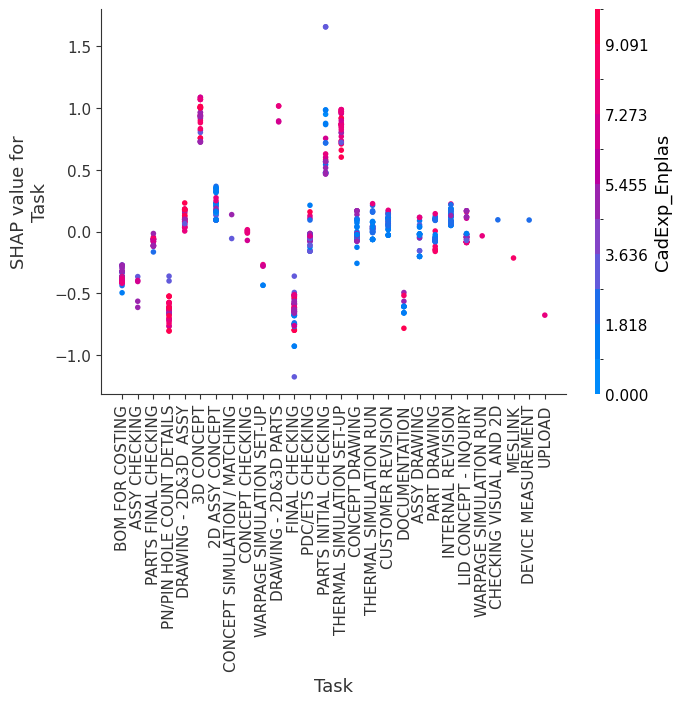

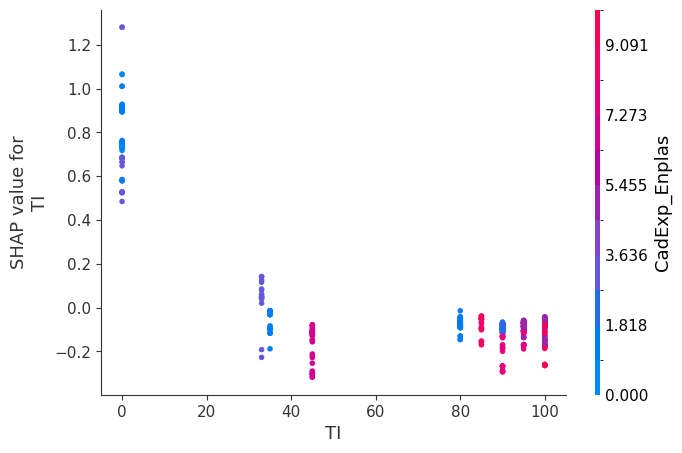

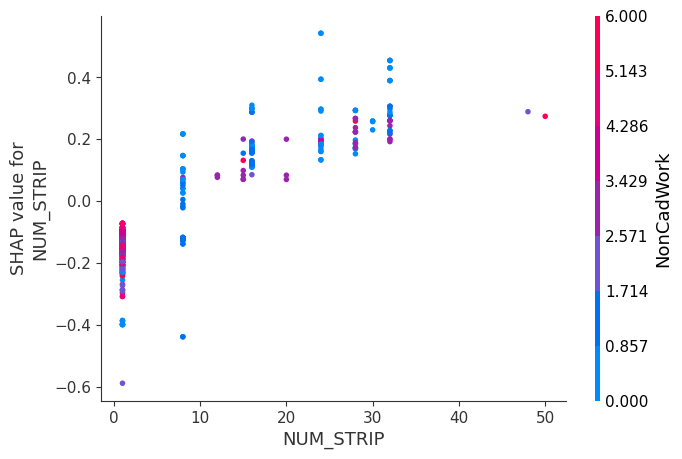

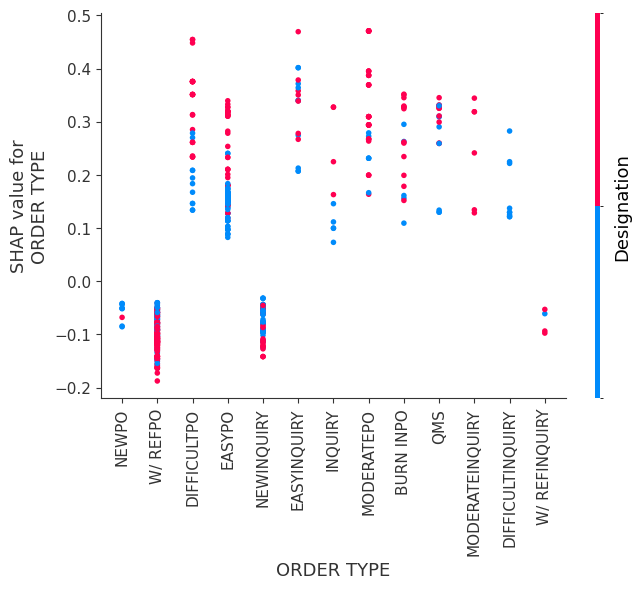

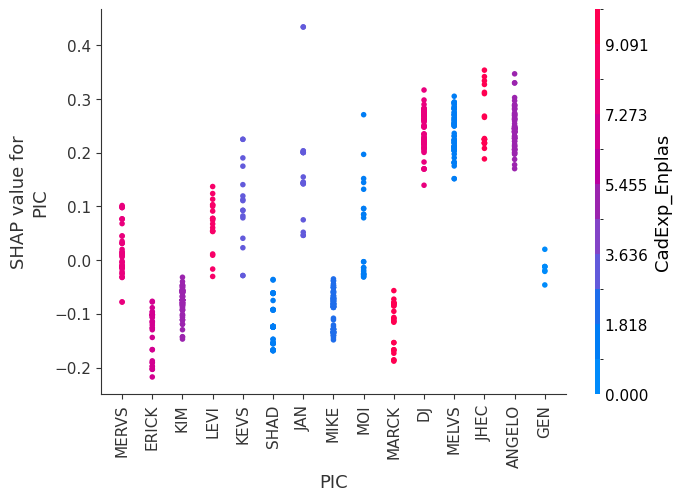

In [ ]:
df_ml_dataset = df_ml_expanded[['Date',  'Task', 'ASSY TYPE', 'PARTS TYPE',
                                'ORDER TYPE', 'SITE_TYPE','PN_PREFIX',
                                'JAGUAR', 'WCSP', 'STRIP', 'BI', 'TI',	'NON TI', 
                                'Designation',
                                'CadExp_Enplas', 'Enplas_Years', 'CADWork_NonEnplas',
                                'NonCadWork', 'Total',
                                'NUM_SITE', 'NUM_STRIP', 'PIC',
                                'Total Adj Time Spent']]

cat_cols = ['Task', 'ASSY TYPE', 'PARTS TYPE',
            'ORDER TYPE', 'SITE_TYPE','PN_PREFIX',
            'JAGUAR', 'WCSP', 'STRIP', 'BI', 'TI',	'NON TI','Designation']

#cat_cols = ['Task', 'ASSY TYPE', 'PARTS TYPE',
            #'ORDER TYPE', 'SITE_TYPE','PN_PREFIX','Designation',"PIC"]

best_model, cv_rmse, rmse, mae, mape, r2 = gbm_hyperparameter_tuning(df_ml_dataset,
                                                          'Total Adj Time Spent',
                                                          cat_cols,
                                                          date_cutoff,
                                                          n_splits)

ml_results_summary['LightGBM']= [best_model, cv_rmse, rmse, mae, mape, r2]

#### Catboost

In [71]:
from catboost import CatBoostRegressor, Pool


def show_model_interpretation(jaguar_model, X_valid):
    X_display = X_valid.copy()

    # Encode categorical features just for SHAP internals
    X_encoded = X_valid.copy()
    for col in X_encoded.select_dtypes(include=['object', 'category']).columns:
        X_encoded[col] = X_encoded[col].astype('category').cat.codes

    explainer = shap.TreeExplainer(jaguar_model)
    shap_values = explainer.shap_values(X_encoded)

    # SHAP summary using original feature names
    shap.summary_plot(shap_values, X_display, plot_type='bar')
    shap.summary_plot(shap_values, X_display)

    # Force plot
    shap.initjs()
    shap.force_plot(explainer.expected_value, shap_values[0], X_display.iloc[0], matplotlib=True)

    # Waterfall plot
    shap.plots.waterfall(shap.Explanation(
        values=shap_values[0],
        base_values=explainer.expected_value,
        data=X_display.iloc[0],
        feature_names=X_display.columns.tolist()
    ))

    # Top features by mean absolute SHAP value
    mean_abs_shap = pd.DataFrame({
        'Feature': X_display.columns,
        'Mean_Abs_SHAP': np.abs(shap_values).mean(axis=0)
    }).sort_values('Mean_Abs_SHAP', ascending=False)

    display(mean_abs_shap.head(20))

    # Dependence plots — use encoded values for SHAP, original for display
    for feature in mean_abs_shap['Feature'].head(5):
        shap.dependence_plot(feature, shap_values, X_encoded, display_features=X_display)




def ml_hyperparameter_tuning(df_ml, target_col, cat_cols,
                              date_cutoff, n_splits=3, gap=0, window_type='expanding',
                              drop_cols=None):

    if drop_cols is None:
        drop_cols = ['Date']

    # --- Step 1: Split data into train/holdout based on date ---
    df = df_ml.sort_values('Date').reset_index(drop=True)
    df_train = df[df['Date'] < date_cutoff].copy()
    df_valid = df[df['Date'] >= date_cutoff].copy()

    category_mappings = {}
    for col in cat_cols:
        df_train[col] = df_train[col].astype('category')
        df_valid[col] = df_valid[col].astype('category')
        category_mappings[col] = dict(enumerate(df_train[col].cat.categories))

    y_train = df_train[target_col]
    y_valid = df_valid[target_col]
    X_train = df_train.drop(columns=[target_col])
    X_valid = df_valid.drop(columns=[target_col])

    # --- Step 2: Drop unwanted columns (e.g., Date) ---
    dropper = ColumnDropper(columns_to_drop=drop_cols)
    X_train_dropped = dropper.fit_transform(X_train)
    X_valid_dropped = dropper.transform(X_valid)

    # --- Step 3: Categorical column names (CatBoost expects names, not indices when using DataFrames) ---
    cat_features = [col for col in cat_cols if col in X_train_dropped.columns]

    # --- Step 4: Cross-validation splitter ---
    splitter = DateTimeSeriesSplit(
        date_column='Date',
        n_splits=n_splits,
        gap=gap,
        window_type=window_type
    )

    # --- Step 5: Optuna objective ---
    def objective(trial):
        params = {
            "iterations": trial.suggest_int("iterations", 300, 1000),
            "depth": trial.suggest_int("depth", 4, 10),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
            "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 10.0, log=True),
            "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
            "border_count": trial.suggest_int("border_count", 32, 255),
            "random_strength": trial.suggest_float("random_strength", 0.0, 10.0),
            "verbose": 0,
            "early_stopping_rounds": 20,
            "task_type": "CPU"
        }

        scores = []
        for train_idx, val_idx in splitter.split(df_train):
            X_tr = X_train_dropped.iloc[train_idx]
            y_tr = y_train.iloc[train_idx]
            X_te = X_train_dropped.iloc[val_idx]
            y_te = y_train.iloc[val_idx]

            train_pool = Pool(X_tr, y_tr, cat_features=cat_features)
            valid_pool = Pool(X_te, y_te, cat_features=cat_features)

            model = CatBoostRegressor(**params)
            model.fit(train_pool, eval_set=valid_pool, use_best_model=True)

            preds = model.predict(X_te)
            scores.append(r2_score(y_te, preds))

        return np.mean(scores)

    # --- Step 6: Run Optuna search ---
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=50, show_progress_bar=True)

    print("Best parameters:", study.best_params)
    print("Best CV R2:", study.best_value)
    cv_r2 = study.best_value

    # --- Step 7: Train final model on full training data ---
    best_params = study.best_params
    best_params.update({
        "verbose": 0,
        "loss_function": "MAE",
        "early_stopping_rounds": 20,
        "task_type": "CPU"
    })

    final_model = CatBoostRegressor(**best_params)
    train_pool = Pool(X_train_dropped, y_train, cat_features=cat_features)
    valid_pool = Pool(X_valid_dropped, y_valid, cat_features=cat_features)
    #final_model.fit(train_pool, eval_set=valid_pool, use_best_model=True)
    final_model.fit(train_pool, use_best_model=True)
    
    y_pred = final_model.predict(X_valid_dropped)
    rmse = root_mean_squared_error(y_valid, y_pred)
    print("Validation RMSE:", rmse)

    mae = mean_absolute_error(y_valid, y_pred)
    print("Validation MAE:", mae)    

    mape = mean_absolute_percentage_error(y_valid, y_pred)
    print("Validation MAPE:", mape)

    r2 = r2_score(y_valid, y_pred)
    print("Validation R2:", r2)    
    
    show_model_interpretation(final_model, X_valid_dropped)

    
    
    return final_model, cv_r2, rmse, mae, mape, r2

[I 2025-05-19 07:40:17,486] A new study created in memory with name: no-name-d406a1d8-ec92-4039-8299-423dd91bb193


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-05-19 07:40:26,693] Trial 0 finished with value: 0.22015912985881314 and parameters: {'iterations': 553, 'depth': 9, 'learning_rate': 0.2160816669771747, 'l2_leaf_reg': 0.02555447023512756, 'bagging_temperature': 0.5561468080411297, 'border_count': 182, 'random_strength': 4.049862200692585}. Best is trial 0 with value: 0.22015912985881314.
[I 2025-05-19 07:40:36,610] Trial 1 finished with value: 0.26208563185391437 and parameters: {'iterations': 763, 'depth': 6, 'learning_rate': 0.13930144968506983, 'l2_leaf_reg': 0.46947019091608616, 'bagging_temperature': 0.11346424606504313, 'border_count': 58, 'random_strength': 9.322500766981221}. Best is trial 1 with value: 0.26208563185391437.
[I 2025-05-19 07:40:55,606] Trial 2 finished with value: 0.2654505121425663 and parameters: {'iterations': 398, 'depth': 8, 'learning_rate': 0.06255479363496225, 'l2_leaf_reg': 0.016224646372508592, 'bagging_temperature': 0.6079940506667845, 'border_count': 167, 'random_strength': 8.14806151890916}

You should provide test set for use best model. use_best_model parameter has been switched to false value.


Validation RMSE: 3.1419875838659066
Validation MAE: 1.7605623594640087
Validation MAPE: 9831887334616.234
Validation R2: 0.3054265389413994


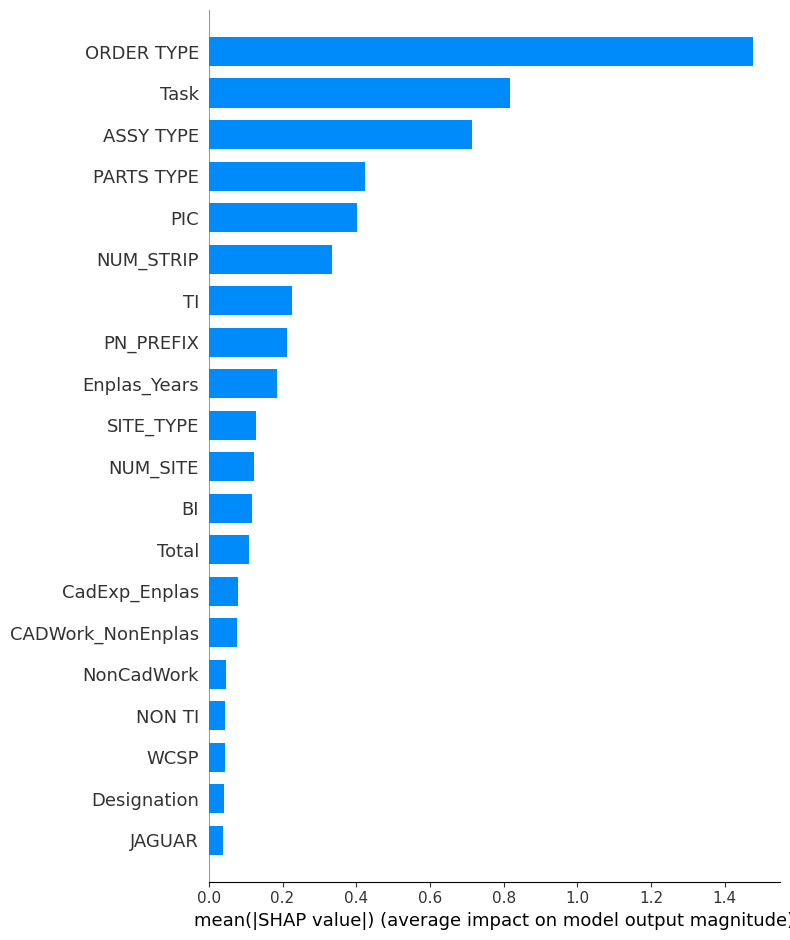

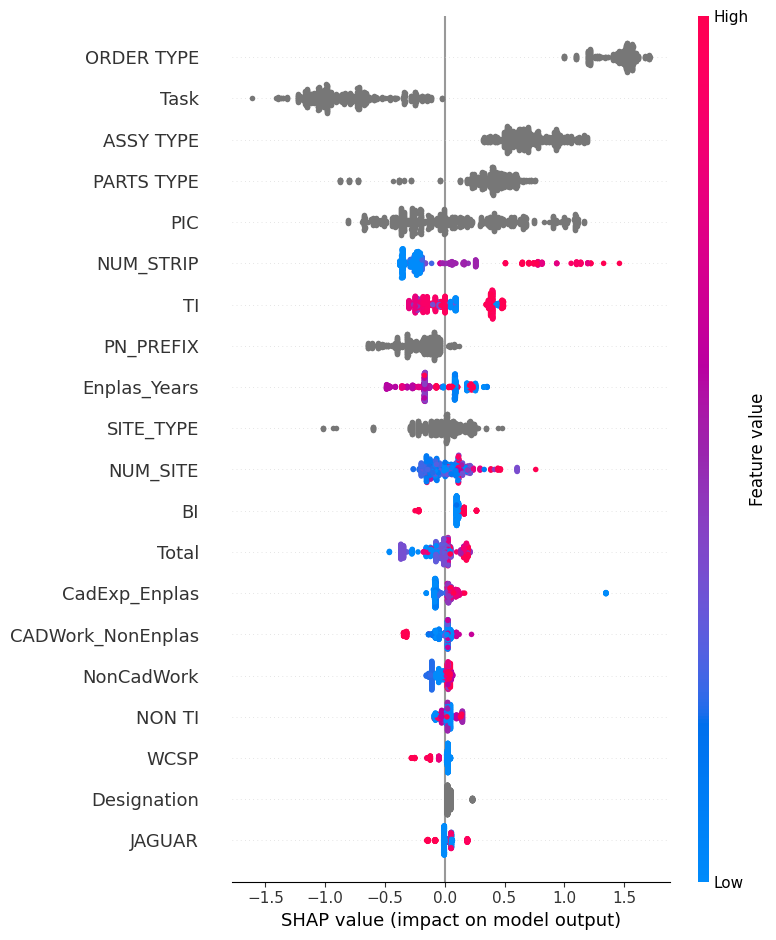

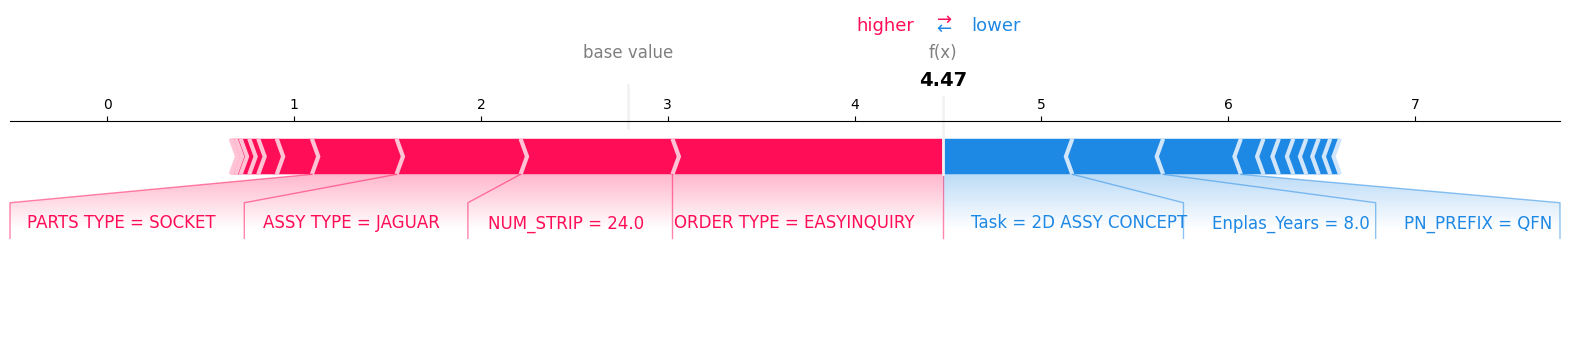

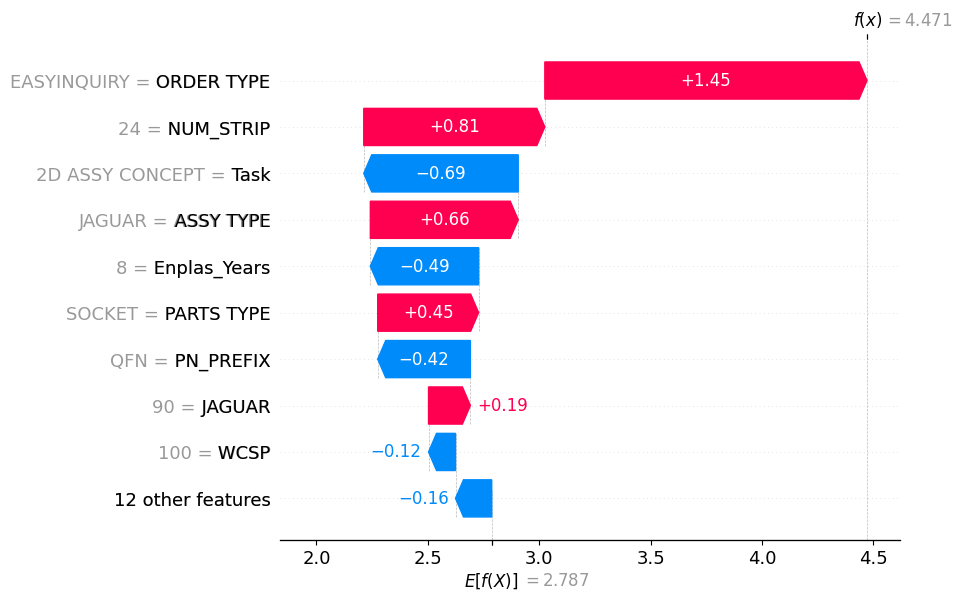

,Feature,Mean_Abs_SHAP
3,ORDER TYPE,1.476533
0,Task,0.818015
1,ASSY TYPE,0.715195
2,PARTS TYPE,0.422796
20,PIC,0.403064
19,NUM_STRIP,0.333808
10,TI,0.225137
5,PN_PREFIX,0.213121
14,Enplas_Years,0.186218
4,SITE_TYPE,0.127630


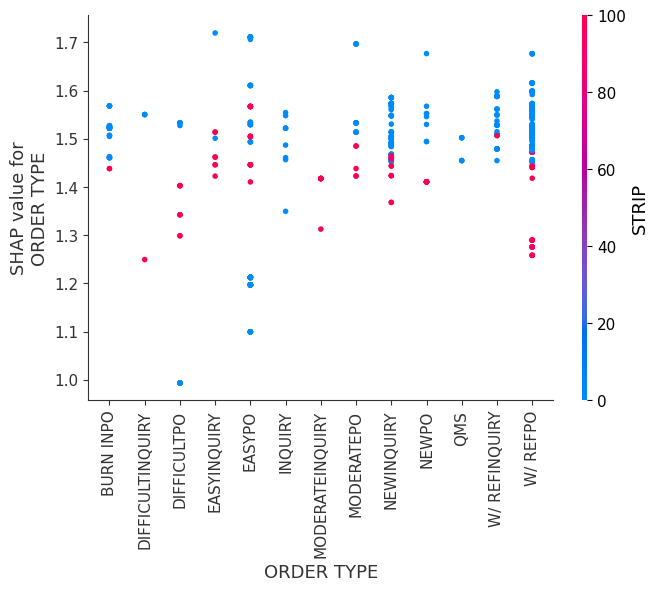

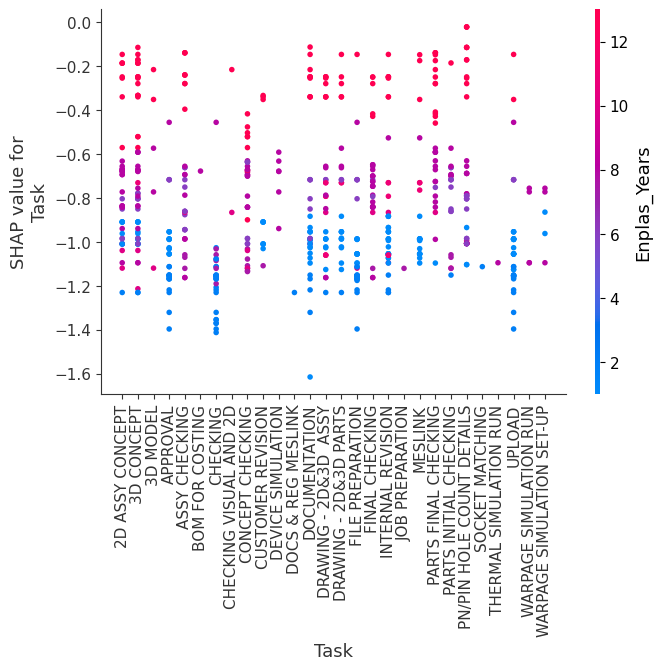

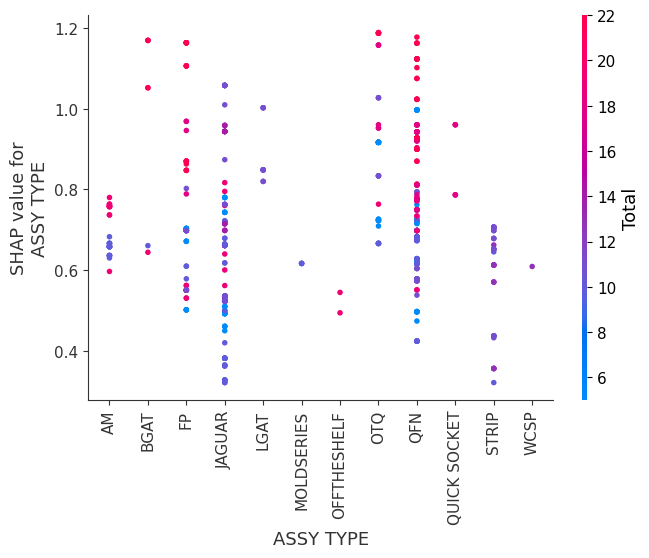

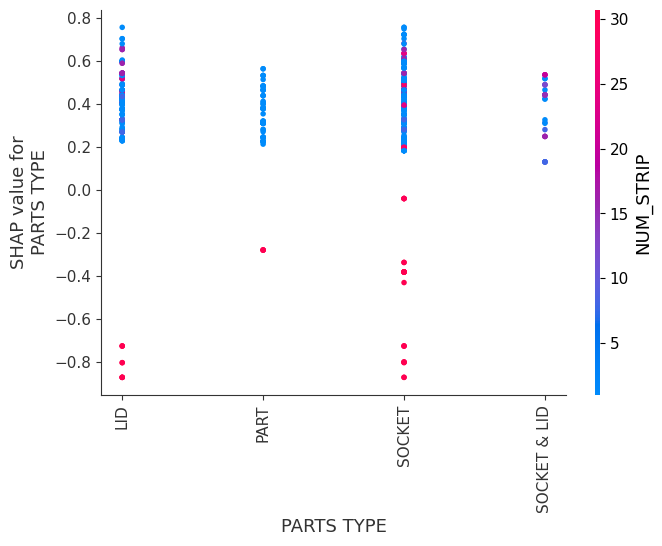

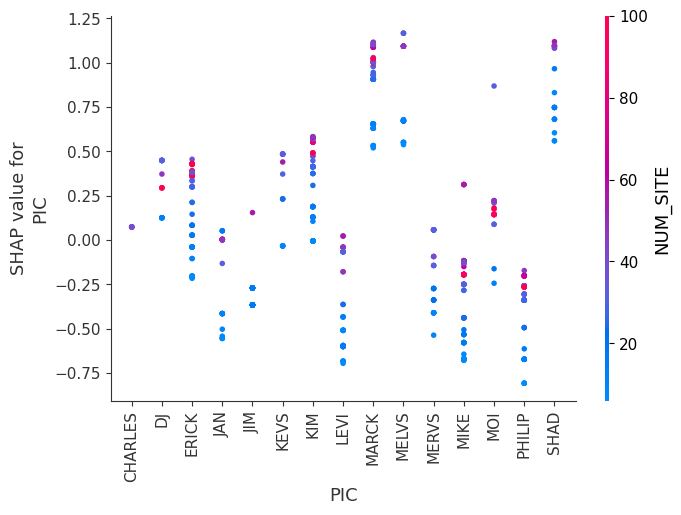

In [72]:
best_model, cv_rmse, rmse, mae, mape, r2 = ml_hyperparameter_tuning(df_ml_dataset,
                                                          'Total Adj Time Spent',
                                                          cat_cols,
                                                          date_cutoff,
                                                          n_splits)

ml_results_summary['CatBoost']= [best_model, cv_rmse, rmse, mae, mape, r2]

#### Linear Regression

In [58]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

def explain_linear_model(model, feature_names, top_n=20):
    coefs = model.coef_
    coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefs})
    coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
    coef_df = coef_df.sort_values('Abs_Coefficient', ascending=False).head(top_n)

    plt.figure(figsize=(10, 6))
    plt.barh(coef_df['Feature'], coef_df['Coefficient'], color='skyblue')
    plt.title('Top Feature Importances')
    plt.axvline(0, color='grey', linewidth=1)
    plt.xlabel('Coefficient Value')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


def tune_regularized_linear_model(df_ml, target_col, cat_cols, date_cutoff,
                                   n_splits=3, gap=0, window_type='expanding', model_type='ridge'):
    assert model_type in ['ridge', 'lasso'], "model_type must be 'ridge' or 'lasso'"

    df = df_ml.sort_values('Date').reset_index(drop=True)

    # Ensure categoricals are strings for OneHotEncoder
    for col in cat_cols:
        df[col] = df[col].astype(str)

    # Train/holdout split
    df_train = df[df['Date'] < date_cutoff].copy()
    df_valid = df[df['Date'] >= date_cutoff].copy()

    y_train = df_train[target_col]
    y_valid = df_valid[target_col]
    X_train = df_train.drop(columns=[target_col])
    X_valid = df_valid.drop(columns=[target_col])

    dropper = ColumnDropper(columns_to_drop=['Date'])
    X_train_dropped = dropper.fit_transform(X_train)
    X_valid_dropped = dropper.transform(X_valid)

    # Detect numeric columns
    num_cols = X_train_dropped.select_dtypes(include=['int64', 'float64']).columns.tolist()
    num_cols = [col for col in num_cols if col not in cat_cols]

    # Preprocessing: One-hot encode categoricals, passthrough numerics
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols),
            ('num', StandardScaler(), num_cols)
        ],
        remainder='drop'  # Only cat and num are kept; others (if any) are dropped
    )

    splitter = DateTimeSeriesSplit(
        date_column='Date',
        n_splits=n_splits,
        gap=gap,
        window_type=window_type
    )

    def objective(trial):
        alpha = trial.suggest_float("alpha", 1e-4, 100.0, log=True)

        scores = []
        for train_idx, val_idx in splitter.split(df_train):
            X_tr = X_train_dropped.iloc[train_idx]
            y_tr = y_train.iloc[train_idx]
            X_te = X_train_dropped.iloc[val_idx]
            y_te = y_train.iloc[val_idx]

            model = Pipeline(steps=[
                ('preprocessor', preprocessor),
                ('lr', Ridge(alpha=alpha) if model_type == 'ridge'
                 else Lasso(alpha=alpha, max_iter=10000))
            ])

            model.fit(X_tr, y_tr)
            preds = model.predict(X_te)
            scores.append(r2_score(y_te, preds))

        return -np.mean(scores)

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50)

    print("Best parameters:", study.best_params)
    print("Best CV R2:", study.best_value)
    
    cv_r2 = study.best_value
    # Final model with best alpha
    alpha = study.best_params['alpha']
    final_model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('lr', Ridge(alpha=alpha) if model_type == 'ridge'
         else Lasso(alpha=alpha, max_iter=10000))
    ])
    final_model.fit(X_train_dropped, y_train)
    y_pred = final_model.predict(X_valid_dropped)

    rmse = root_mean_squared_error(y_valid, y_pred)
    print("Validation RMSE:", rmse)

    mae = mean_absolute_error(y_valid, y_pred)
    print("Validation MAE:", mae)

    mape = mean_absolute_percentage_error(y_valid, y_pred)
    print("Validation MAPE:", mape)

    r2 = r2_score(y_valid, y_pred)
    print("Validation R2:", r2)       

    # Extract and display feature importances
    ohe = final_model.named_steps['preprocessor'].named_transformers_['cat']
    ohe_feature_names = ohe.get_feature_names_out(cat_cols)
    all_feature_names = np.concatenate([ohe_feature_names, num_cols])

    lr_model = final_model.named_steps['lr']
    explain_linear_model(lr_model, all_feature_names)

    return final_model, cv_r2, rmse, mae, mape, r2

##### Ridge Regression

[I 2025-05-18 17:55:29,265] A new study created in memory with name: no-name-398caec6-8666-47af-8f46-6796ea67f6cc
[I 2025-05-18 17:55:29,370] Trial 0 finished with value: 0.10525612958675774 and parameters: {'alpha': 0.0003443201678285476}. Best is trial 0 with value: 0.10525612958675774.
[I 2025-05-18 17:55:29,453] Trial 1 finished with value: -0.023799242422381555 and parameters: {'alpha': 2.3387004585047375}. Best is trial 1 with value: -0.023799242422381555.
[I 2025-05-18 17:55:29,578] Trial 2 finished with value: 0.03699107539054151 and parameters: {'alpha': 0.660107903260897}. Best is trial 1 with value: -0.023799242422381555.
[I 2025-05-18 17:55:29,703] Trial 3 finished with value: 0.10563985926638515 and parameters: {'alpha': 0.0003117837294038299}. Best is trial 1 with value: -0.023799242422381555.
[I 2025-05-18 17:55:29,809] Trial 4 finished with value: 0.09493968349630248 and parameters: {'alpha': 0.0019921404717276304}. Best is trial 1 with value: -0.023799242422381555.
[I 

Best parameters: {'alpha': 65.27825891833281}
Best CV R2: -0.148685714582237
Validation RMSE: 3.3004859948276715
Validation MAE: 2.1820993968557825
Validation MAPE: 18134177037262.02
Validation R2: 0.2335831492349112


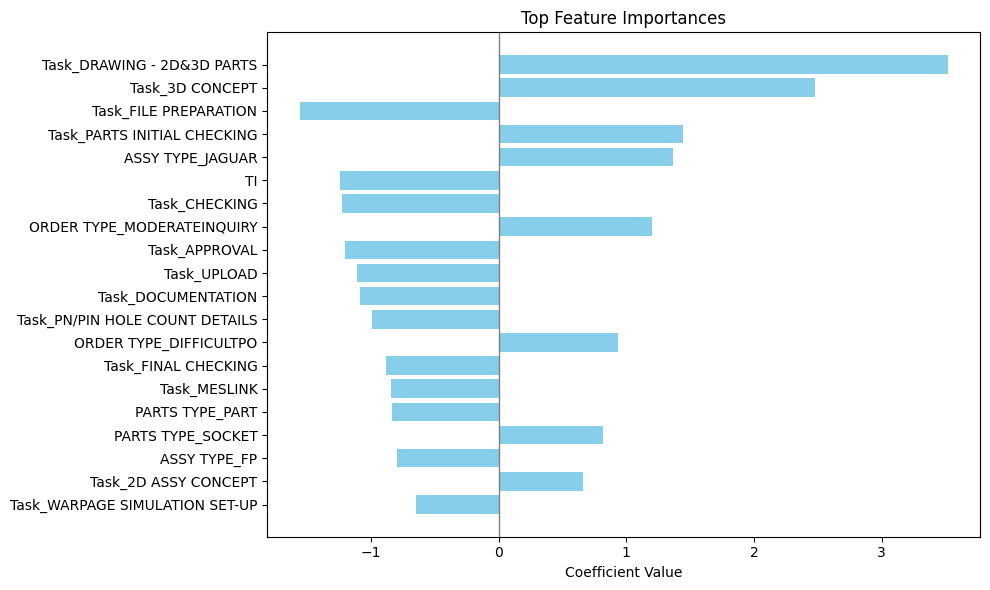

In [59]:
best_model, cv_rmse, rmse, mae, mape, r2 = tune_regularized_linear_model(df_ml_dataset,
                                                               'Total Adj Time Spent',
                                                               cat_cols, 
                                                               date_cutoff,
                                                               n_splits)
ml_results_summary['Ridge']= [best_model, cv_rmse, rmse, mae, mape, r2]

##### Lasso Regression

[I 2025-05-18 17:55:44,175] A new study created in memory with name: no-name-67f8290e-a3d3-4857-a9f2-6ba15ee4ae01
[I 2025-05-18 17:55:44,270] Trial 0 finished with value: -0.056679928014092384 and parameters: {'alpha': 0.01693816014208909}. Best is trial 0 with value: -0.056679928014092384.
[I 2025-05-18 17:55:44,349] Trial 1 finished with value: 0.029550049449781495 and parameters: {'alpha': 6.560363204678533}. Best is trial 0 with value: -0.056679928014092384.
[I 2025-05-18 17:55:44,814] Trial 2 finished with value: 0.012459634495015673 and parameters: {'alpha': 0.0019130969482415363}. Best is trial 0 with value: -0.056679928014092384.
[I 2025-05-18 17:55:44,881] Trial 3 finished with value: -0.11784143909240903 and parameters: {'alpha': 0.03288927674458218}. Best is trial 3 with value: -0.11784143909240903.
[I 2025-05-18 17:55:45,287] Trial 4 finished with value: -0.004305980000399205 and parameters: {'alpha': 0.0027405460881963725}. Best is trial 3 with value: -0.11784143909240903.

Best parameters: {'alpha': 0.07686568307557977}
Best CV R2: -0.16338988123593215
Validation RMSE: 3.501786346014247
Validation MAE: 2.3871530629594
Validation MAPE: 15102890332471.502
Validation R2: 0.1372428913393493


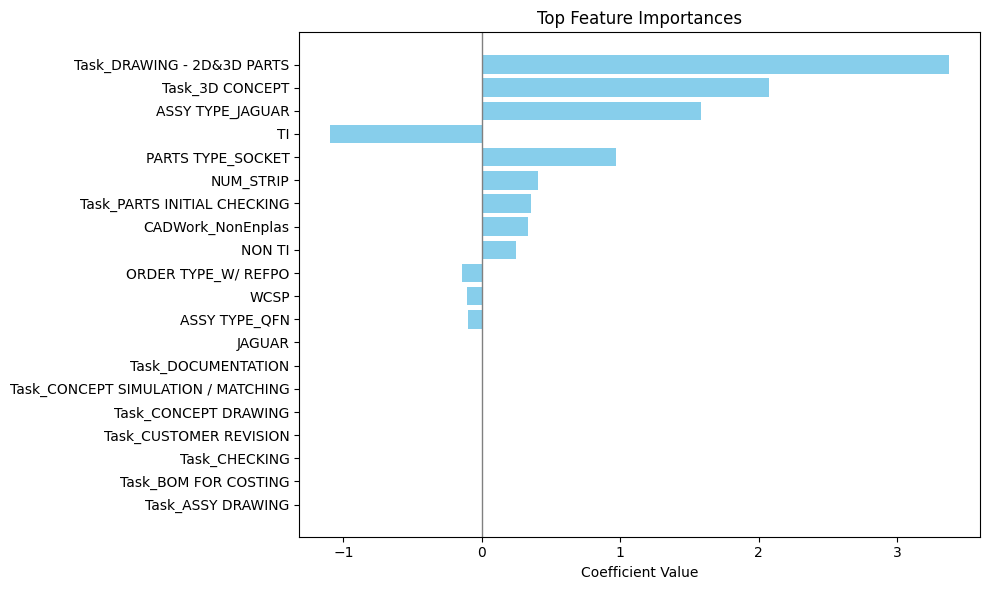

In [60]:
best_model, cv_rmse, rmse, mae, mape, r2 = tune_regularized_linear_model(df_ml_dataset,
                                                               'Total Adj Time Spent',
                                                               cat_cols,
                                                               date_cutoff,
                                                               n_splits,
                                                               model_type='lasso')
ml_results_summary['Lasso']= [best_model, cv_rmse, rmse, mae, mape, r2]

#### Random Forest

In [61]:
from sklearn.ensemble import RandomForestRegressor

def show_rf_model_explainability(model_pipeline, X_valid):
    # Extract the trained RandomForestRegressor and transformed data
    preprocessor = model_pipeline.named_steps['preprocessor']
    rf_model = model_pipeline.named_steps['rf']
    
    # Transform X_valid using the preprocessor to get encoded features
    X_transformed = preprocessor.transform(X_valid)

    # Get feature names after transformation
    try:
        feature_names = preprocessor.get_feature_names_out()
    except:
        # fallback for older sklearn versions
        cat_features = preprocessor.transformers_[0][2]
        feature_names = (
            model_pipeline.named_steps['preprocessor']
            .named_transformers_['cat']
            .get_feature_names(cat_features)
            .tolist()
        )
        remainder_features = [col for col in X_valid.columns if col not in cat_features]
        feature_names += remainder_features

    # Create a DataFrame for SHAP
    X_transformed_df = pd.DataFrame(X_transformed.toarray() if hasattr(X_transformed, "toarray") else X_transformed,
                                    columns=feature_names)

    explainer = shap.TreeExplainer(rf_model)
    shap_values = explainer.shap_values(X_transformed_df)

    # Summary plots
    shap.summary_plot(shap_values, X_transformed_df, plot_type="bar")
    shap.summary_plot(shap_values, X_transformed_df)

    # Force + waterfall plot for one example
    shap.initjs()
    shap.force_plot(explainer.expected_value, shap_values[0], X_transformed_df.iloc[0], matplotlib=True)
    shap.plots.waterfall(shap.Explanation(
        values=shap_values[0],
        base_values=explainer.expected_value,
        data=X_transformed_df.iloc[0],
        feature_names=X_transformed_df.columns.tolist()
    ))

    # Top features
    mean_abs_shap = pd.DataFrame({
        'Feature': X_transformed_df.columns,
        'Mean_Abs_SHAP': np.abs(shap_values).mean(axis=0)
    }).sort_values('Mean_Abs_SHAP', ascending=False)

    display(mean_abs_shap.head(10))

    for feature in mean_abs_shap['Feature'].head(3):
        shap.dependence_plot(feature, shap_values, X_transformed_df)

def tune_random_forest_model(df_ml, target_col, cat_cols, date_cutoff,
                                   n_splits=3, gap=0, window_type='expanding'):

    df = df_ml.sort_values('Date').reset_index(drop=True)

    # Ensure categoricals are strings for OneHotEncoder
    for col in cat_cols:
        df[col] = df[col].astype(str)

    # Train/holdout split
    df_train = df[df['Date'] < date_cutoff].copy()
    df_valid = df[df['Date'] >= date_cutoff].copy()

    y_train = df_train[target_col]
    y_valid = df_valid[target_col]
    X_train = df_train.drop(columns=[target_col])
    X_valid = df_valid.drop(columns=[target_col])

    dropper = ColumnDropper(columns_to_drop=['Date'])
    X_train_dropped = dropper.fit_transform(X_train)
    X_valid_dropped = dropper.transform(X_valid)

    # Detect numeric columns
    num_cols = X_train_dropped.select_dtypes(include=['int64', 'float64']).columns.tolist()
    num_cols = [col for col in num_cols if col not in cat_cols]

    # Preprocessing: One-hot encode categoricals, passthrough numerics
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
        ],
        remainder='passthrough'
    )

    splitter = DateTimeSeriesSplit(
        date_column='Date',
        n_splits=n_splits,
        gap=gap,
        window_type=window_type
    )

    def objective(trial):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 500),
            "max_depth": trial.suggest_int("max_depth", 5, 20),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 5),
            "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None])
        }
        scores = []
        for train_idx, val_idx in splitter.split(df_train):
            X_tr = X_train_dropped.iloc[train_idx]
            y_tr = y_train.iloc[train_idx]
            X_te = X_train_dropped.iloc[val_idx]
            y_te = y_train.iloc[val_idx]
    
            model = Pipeline(steps=[
                ('preprocessor', preprocessor),
                ('rf', RandomForestRegressor(**params, random_state=42))
            ])

            model.fit(X_tr, y_tr)
            preds = model.predict(X_te)
            scores.append(r2_score(y_te, preds))

        return np.mean(scores)

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=50)

    print("Best parameters:", study.best_params)
    print("Best CV R2:", study.best_value)

    cv_r2 = study.best_value

    best_params = study.best_params
    final_model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('rf', RandomForestRegressor(**best_params, random_state=42))
    ])
    final_model.fit(X_train_dropped, y_train)
    y_pred = final_model.predict(X_valid_dropped)

    rmse = root_mean_squared_error(y_valid, y_pred)
    print("Validation RMSE:", rmse)

    mae = mean_absolute_error(y_valid, y_pred)
    print("Validation MAE:", mae)

    mape = mean_absolute_percentage_error(y_valid, y_pred)
    print("Validation MAPE:", mape)

    r2 = r2_score(y_valid, y_pred)
    print("Validation R2:", r2)   
    
    show_rf_model_explainability(final_model, X_valid_dropped)
    
    return final_model, cv_r2, rmse, mae, mape, r2

[I 2025-05-18 17:56:19,129] A new study created in memory with name: no-name-1641f1c9-2125-4a67-9ce1-7e7dd3dd3717


[I 2025-05-18 17:56:20,520] Trial 0 finished with value: 0.17689766864677517 and parameters: {'n_estimators': 221, 'max_depth': 19, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.17689766864677517.
[I 2025-05-18 17:56:21,169] Trial 1 finished with value: 0.16304058369371177 and parameters: {'n_estimators': 148, 'max_depth': 11, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 0 with value: 0.17689766864677517.
[I 2025-05-18 17:56:23,268] Trial 2 finished with value: 0.16985290037900821 and parameters: {'n_estimators': 439, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.17689766864677517.
[I 2025-05-18 17:56:25,886] Trial 3 finished with value: 0.17216286765233443 and parameters: {'n_estimators': 469, 'max_depth': 19, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.1768976

Best parameters: {'n_estimators': 104, 'max_depth': 11, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': None}
Best CV R2: 0.2058897502073412
Validation RMSE: 3.260036533506027
Validation MAE: 1.9810420175824925
Validation MAPE: 12760638183735.727
Validation R2: 0.2522538418856337


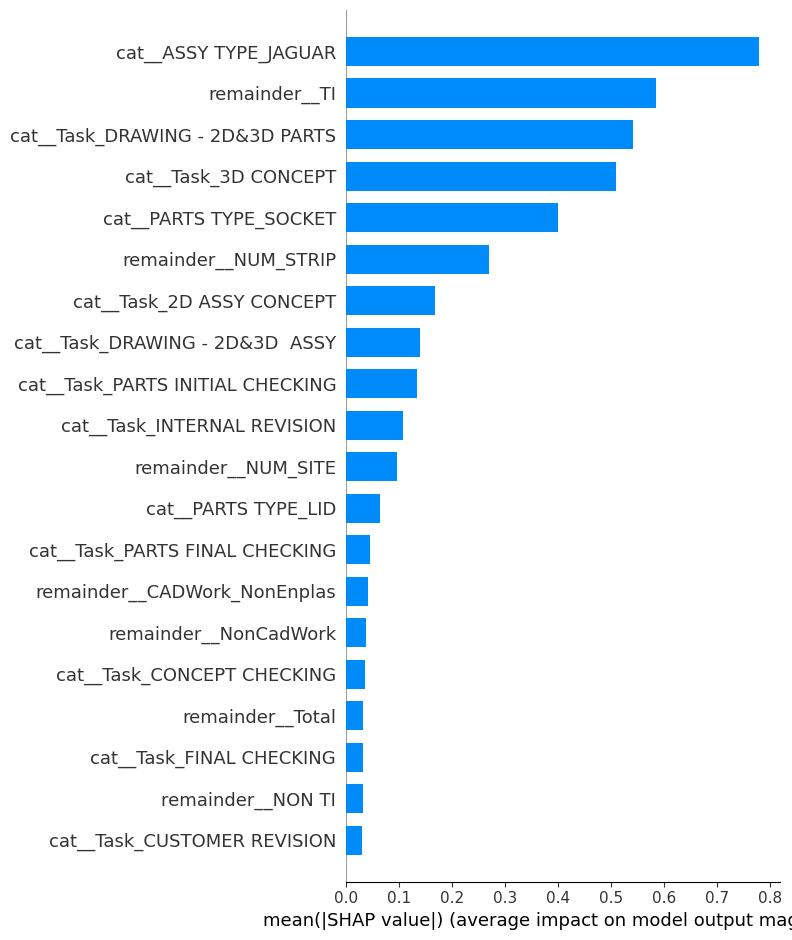

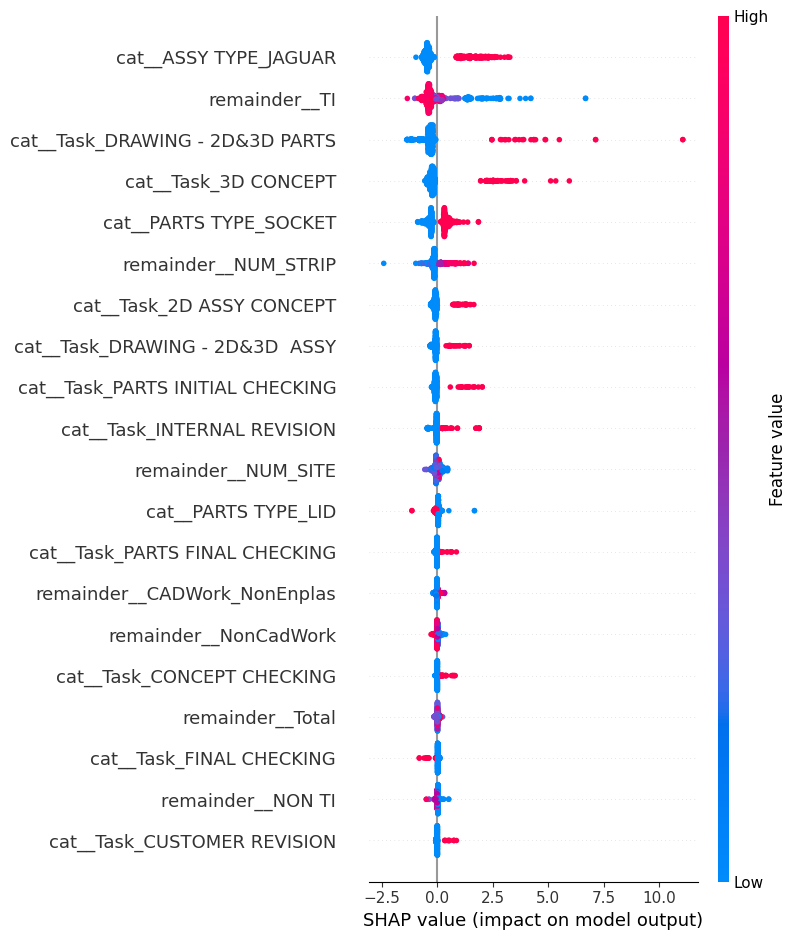

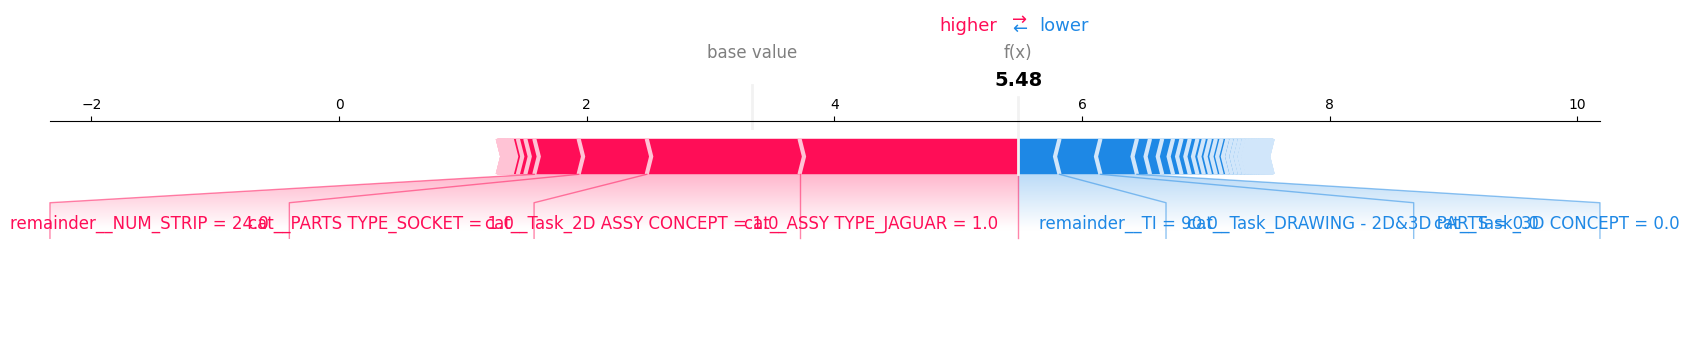

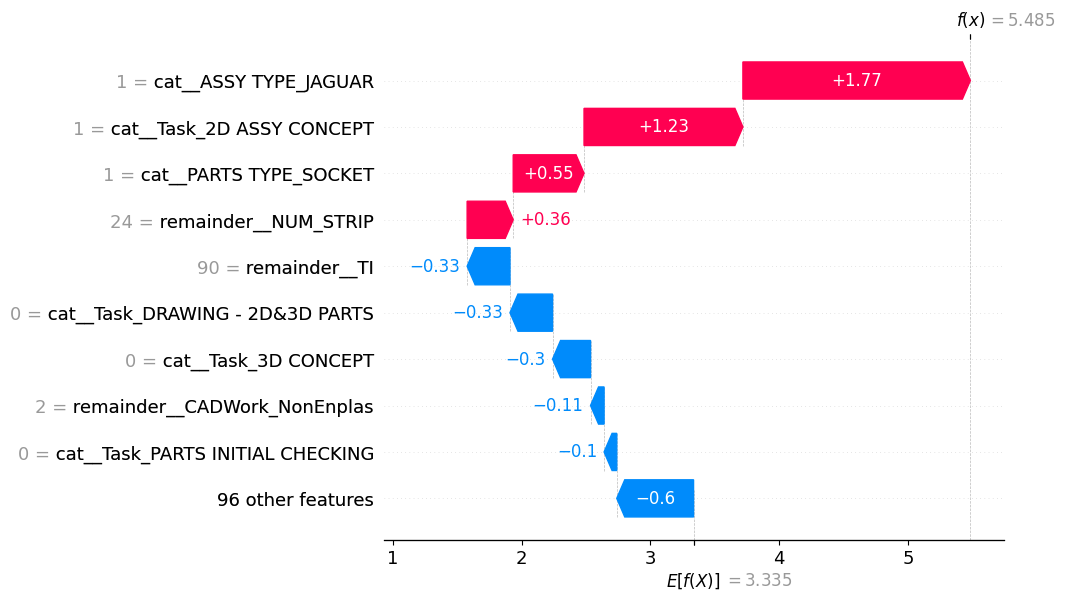

,Feature,Mean_Abs_SHAP
37,cat__ASSY TYPE_JAGUAR,0.779208
96,remainder__TI,0.583887
18,cat__Task_DRAWING - 2D&3D PARTS,0.540908
2,cat__Task_3D CONCEPT,0.508702
48,cat__PARTS TYPE_SOCKET,0.399891
104,remainder__NUM_STRIP,0.270219
0,cat__Task_2D ASSY CONCEPT,0.167848
17,cat__Task_DRAWING - 2D&3D ASSY,0.138909
26,cat__Task_PARTS INITIAL CHECKING,0.134668
21,cat__Task_INTERNAL REVISION,0.107472


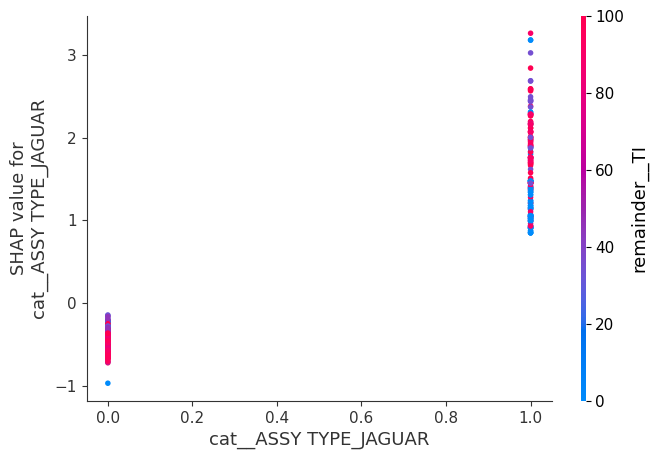

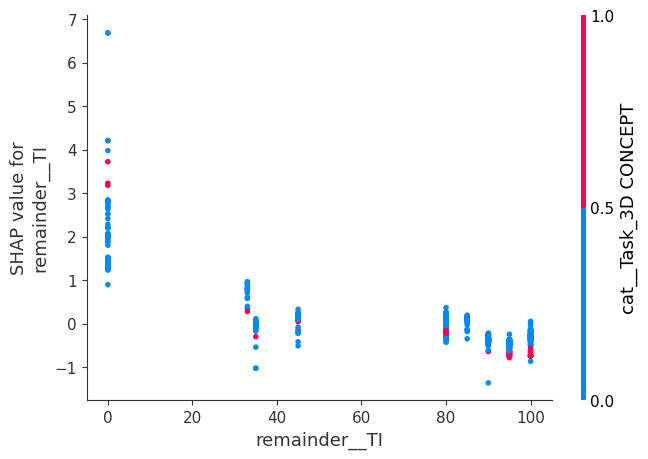

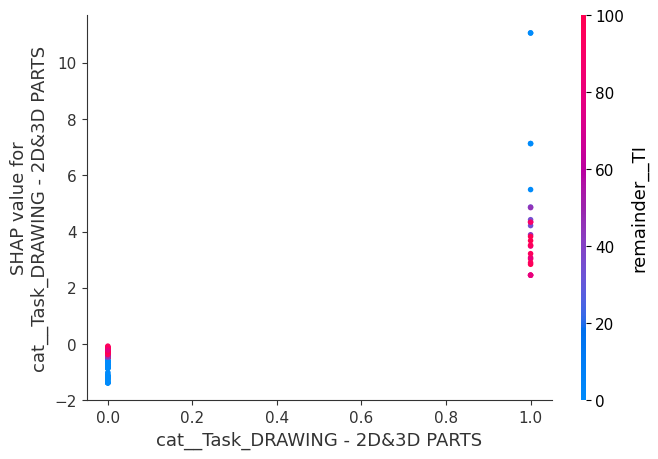

In [62]:
best_model, cv_rmse, rmse, mae, mape, r2 = tune_random_forest_model(df_ml_dataset,
                                                          'Total Adj Time Spent',
                                                          cat_cols,
                                                          date_cutoff,
                                                          n_splits)
ml_results_summary['Random Forest']= [best_model, cv_rmse, rmse, mae, mape, r2]

#### Summarize Results

In [63]:
data=[]
for key, value in ml_results_summary.items():
    data.append([key, value[1], value[2], value[3], value[4], value[5]])
df_summary = pd.DataFrame(data, columns=['Model','CV R2','Holdout RMSE','Holdout MAE','Holdout MAPE','Holdout R2'])
display(df_summary)

,Model,CV R2,Holdout RMSE,Holdout MAE,Holdout MAPE,Holdout R2
0,Baseline,-0.335544,3.684025,2.045451,2.178397e+13,0.045107
1,LightGBM,0.289295,3.754346,2.652043,2.466462e+13,0.008305
2,CatBoost,0.295549,3.066751,1.663977,1.187033e+13,0.338292
3,Ridge,-0.148686,3.300486,2.182099,1.813418e+13,0.233583
4,Lasso,-0.163390,3.501786,2.387153,1.510289e+13,0.137243
5,Random Forest,0.205890,3.260037,1.981042,1.276064e+13,0.252254


#### Check suitability for ARIMA
- aggregate by getting count, mean, and std per Product-Assy Type, Task, and Date combination
- check for combinations with more than 55 data points (50 for fitting then 5 for prediction)

In [64]:
def prepare_pseudo_arima_dataset(df):
    df['Date'] = pd.to_datetime(df['Date'])
    
    grouped = (
        df.groupby(['PRODUCT-ASSY TYPE', 'Task', 'Date'])['Total Adj Time Spent']
          .agg(
              job_count='count',
              avg_takt='mean',
              std_takt='std'
          )
          .reset_index()
    )
    return grouped

In [65]:
df_arima = prepare_pseudo_arima_dataset(df_ml)

In [66]:
df_grouping = df_arima.groupby(['PRODUCT-ASSY TYPE','Task']).size().reset_index(name='count')
df_grouping[df_grouping['count']>=55]

,PRODUCT-ASSY TYPE,Task,count


In [67]:
ml_results_summary['CatBoost'][0].save_model("catboost_model.cbm")

In [68]:
df_ml_dataset.head(3)


,Date,Task,ASSY TYPE,PARTS TYPE,ORDER TYPE,SITE_TYPE,PN_PREFIX,JAGUAR,WCSP,STRIP,...,NON TI,Designation,CadExp_Enplas,Enplas_Years,CADWork_NonEnplas,NonCadWork,Total,NUM_SITE,NUM_STRIP,Total Adj Time Spent
0,2024-05-21,DRAWING - 2D&3D ASSY,JAGUAR,SOCKET,DIFFICULTPO,EPK,QFN,85.0,0.0,0.0,...,0.0,ADE,3.0,11.0,0.0,0.0,11.0,28.0,32.0,27.0
1,2024-05-21,FINAL CHECKING,JAGUAR,SOCKET,DIFFICULTPO,EPK,QFN,95.0,0.0,0.0,...,100.0,ADE,10.0,14.0,0.0,0.0,14.0,28.0,32.0,3.0
2,2024-04-17,THERMAL SIMULATION SET-UP,JAGUAR,SOCKET,DIFFICULTPO,EPK,QFN,100.0,100.0,100.0,...,100.0,DE,10.0,13.0,0.0,6.0,19.0,28.0,32.0,7.0
